In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import math
torch.manual_seed(8)
import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP.AttentiveLayers_Sim_copy import Fingerprint, GRN, AFSE
from AttentiveFP import Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer
from AttentiveFP.utils import EarlyStopping, eval
from AttentiveFP.utils import Meter
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import AttentiveFP.Featurizer
import scipy

In [3]:
train_filename = "./data/IC50_O43614_1_train.csv"
test_filename = "./data/IC50_O43614_1_test.csv"
train_rate = 1
val_rate = 0.2
random_seed = 68
batch_size = 10
file_list1 = train_filename.split('/')
file1 = file_list1[-1]
file1 = file1[:-10]
run_number = '_run_1'
model_file = "model_file/G_AFSE_"+file1+run_number
log_dir = f'log/{"G_AFSE_"+file1}'+run_number
print(file1)
print(model_file)

IC50_O43614_1
model_file/G_AFSE_IC50_O43614_1_run_1


In [4]:
# task_name = 'Malaria Bioactivity'
tasks = ['value']

# train_filename = "../data/active_inactive/median_active/EC50/Q99500.csv"
feature_filename = train_filename.replace('.csv','.pickle')
filename = train_filename.replace('.csv','')
prefix_filename = train_filename.split('/')[-1].replace('.csv','')
train_df = pd.read_csv(train_filename, header=0, names = ["smiles","value"],usecols=[1,2])
# train_df = train_df[1:]
# train_df = train_df.drop(0,axis=1,inplace=False) 
print(train_df[:5])
# print(train_df.iloc(1))
def add_canonical_smiles(train_df):
    smilesList = train_df.smiles.values
    print("number of all smiles: ",len(smilesList))
    atom_num_dist = []
    remained_smiles = []
    canonical_smiles_list = []
    for smiles in smilesList:
        try:        
            mol = Chem.MolFromSmiles(smiles)
            atom_num_dist.append(len(mol.GetAtoms()))
            remained_smiles.append(smiles)
            canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
        except:
            print(smiles)
            pass
    print("number of successfully processed smiles: ", len(remained_smiles))
    train_df = train_df[train_df["smiles"].isin(remained_smiles)]
    train_df['cano_smiles'] =canonical_smiles_list
    return train_df
# print(train_df)
train_df = add_canonical_smiles(train_df)

print(train_df.head())
# plt.figure(figsize=(5, 3))
# sns.set(font_scale=1.5)
# ax = sns.distplot(atom_num_dist, bins=28, kde=False)
# plt.tight_layout()
# # plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
# plt.show()
# plt.close()


                                              smiles     value
0  CC1=CC(=C(C=C1)N2N=CC=N2)C(=O)N3CCCC3C4=NC(=NO... -1.602060
1  COC1=C(C=CC=C1F)C2=NOC(=N2)C3CCCN3C(=O)C4=C(C=... -0.954243
2  CC1=CC=CC(=C1)C2=C(N=CO2)C(=O)NC3=CN(N=C3)CCN4... -2.705008
3  CC1CC(N(C1=O)CC2=CC3=C(C=C2)OC4=CC=CC=C43)C5=C... -0.778151
4  CNC(=O)C(C1=CC=CC=C1)N2CCN3C(=NC(=C3C2CCC4=CC(... -0.845098
number of all smiles:  2619
number of successfully processed smiles:  2619
                                              smiles     value  \
0  CC1=CC(=C(C=C1)N2N=CC=N2)C(=O)N3CCCC3C4=NC(=NO... -1.602060   
1  COC1=C(C=CC=C1F)C2=NOC(=N2)C3CCCN3C(=O)C4=C(C=... -0.954243   
2  CC1=CC=CC(=C1)C2=C(N=CO2)C(=O)NC3=CN(N=C3)CCN4... -2.705008   
3  CC1CC(N(C1=O)CC2=CC3=C(C=C2)OC4=CC=CC=C43)C5=C... -0.778151   
4  CNC(=O)C(C1=CC=CC=C1)N2CCN3C(=NC(=C3C2CCC4=CC(... -0.845098   

                                         cano_smiles  
0  Cc1ccc(-n2nccn2)c(C(=O)N2CCCC2c2nc(-c3c(C)cccc...  
1  COc1c(F)cccc1-c1noc(C2CCCN2C(=O)c2cc(

In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

p_dropout= 0.03
fingerprint_dim = 100

weight_decay = 4.3 # also known as l2_regularization_lambda
learning_rate = 4
radius = 2
T = 1
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
test_df = pd.read_csv(test_filename,header=0,names=["smiles","value","matched_smiles","matched_cano_smiles","matched_value"],usecols=[1,2,4,5,6])
test_df = add_canonical_smiles(test_df)
for l in test_df["cano_smiles"]:
    if l in train_df["cano_smiles"]:
        print("same smiles:",l)
        
print(test_df.shape)
print(test_df.head())

number of all smiles:  81
number of successfully processed smiles:  81
(81, 6)
                                              smiles     value  \
0  CCC1=NC(=C2N1CCN(C2CCC3=CC=C(C=C3)C(F)(F)F)C(C... -1.146128   
1  COC1=C(C=C(C=C1)CC2COCCN2C(=O)C3=CC=CC=C3N4N=C... -1.491362   
2  CC1=CC(=C(C=C1)N2N=CC=N2)C(=O)N3CCCC3C4=NC(=NO... -1.505150   
3  COC1=C(C(=CC=C1)OC)C2CC(C(=O)N2CC3=CC4=C(C=C3)... -0.602060   
4  CC1=CC(=C(C=C1)N2N=CC=N2)C(=O)N3CCCCC3CC4=CC(=... -0.301030   

                                      matched_smiles  \
0  CCC1=NC(=C2N1CCN(C2CCC3=CC=C(C=C3)C(F)(F)F)C(C...   
1  COC1=C(C=C(C=C1)CC2COCCN2C(=O)C3=CC=CC=C3N4N=C...   
2  CC1=CC(=C(C=C1)N2N=CC=N2)C(=O)N3CCCC3C4=NC(=NO...   
3  COC1=C(C(=CC=C1)OC)C2CC(C(=O)N2CC3=CC4=C(C=C3)...   
4  CC1=CC(=C(C=C1)N2N=CC=N2)C(=O)N3CCOCC3CC4=CC(=...   

                                 matched_cano_smiles  matched_value  \
0  CCOc1nc(CC)n2c1C(CCc1ccc(C(F)(F)F)cc1)N(C(C(=O...      -3.438701   
1  COc1ccc(CC2COCCN2C(=O)c2ccccc2-n2nccn2)cc1

In [7]:
print(feature_filename)
print(filename)
total_df = pd.concat([train_df,test_df],axis=0)
total_smilesList = total_df['smiles'].values
print(len(total_smilesList))
# if os.path.isfile(feature_filename):
#     feature_dicts = pickle.load(open(feature_filename, "rb" ))
# else:
#     feature_dicts = save_smiles_dicts(smilesList,filename)
feature_dicts = save_smiles_dicts(total_smilesList,filename)
remained_df = total_df[total_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = total_df.drop(remained_df.index)

./data/IC50_O43614_1_train.pickle
./data/IC50_O43614_1_train
2700
feature dicts file saved as ./data/IC50_O43614_1_train.pickle


In [8]:
# train_df = train_df[:train_active]
val_df = train_df.sample(frac=val_rate,random_state=random_seed)
train_df = train_df.drop(val_df.index)
train_df = train_df.reset_index(drop=True)
train_df = train_df[train_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
train_df = train_df.reset_index(drop=True)
val_df = val_df[val_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
val_df = val_df.reset_index(drop=True)
test_df = test_df[test_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
test_df = test_df.reset_index(drop=True)
print(train_df.shape,val_df.shape,test_df.shape)

(2095, 3) (524, 3) (81, 6)


In [9]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([total_df["cano_smiles"].values[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
amodel = AFSE(fingerprint_dim, output_units_num, p_dropout)
gmodel = GRN(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, p_dropout)
model.cuda()
amodel.cuda()
gmodel.cuda()

optimizer = optim.Adam(params=model.parameters(), lr=10**(-learning_rate), weight_decay=10**-weight_decay)

optimizer_AFSE = optim.Adam(params=amodel.parameters(), lr=10**(-learning_rate), weight_decay=10**-weight_decay)

# optimizer_AFSE = optim.SGD(params=amodel.parameters(), lr = 0.01, momentum=0.9)

optimizer_GRN = optim.Adam(params=gmodel.parameters(), lr=10**(-learning_rate), weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
# print(params)
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data.shape)
        

In [10]:
import numpy as np
from matplotlib import pyplot as plt

def sorted_show_pik(dataset, p, k, k_predict, i, acc):
    p_value = dataset[tasks[0]].astype(float).tolist()
    x = np.arange(0,len(dataset),1)
#     print('plt',dataset.head(),p[:10],k_predict,k)
#     plt.figure()
#     fig, ax1 = plt.subplots()
#     ax1.grid(False)
#     ax2 = ax1.twinx()
#     plt.grid(False)
    plt.scatter(x,p,marker='.',s=6,color='r',label='predict')
#     plt.ylabel('predict')
    plt.scatter(x,p_value,s=6,marker=',',color='blue',label='p_value')
    plt.axvline(x=k-1,ls="-",c="black")#添加垂直直线
    k_value = np.ones(len(dataset))
# #     print(EC50[k-1])
    k_value = k_value*k_predict
    plt.plot(x,k_value,'-',color='black')
    plt.ylabel('p_value')
    plt.title("epoch: {},  top-k recall: {}".format(i,acc))
    plt.legend(loc=3,fontsize=5)
    plt.show()
    

def topk_acc2(df, predict, k, active_num, show_flag=False, i=0):
    df['predict'] = predict
    df2 = df.sort_values(by='predict',ascending=False) # 拼接预测值后对预测值进行排序
#     print('df2:\n',df2)
    
    df3 = df2[:k]  #取按预测值排完序后的前k个
    
    true_sort = df.sort_values(by=tasks[0],ascending=False) #返回一个新的按真实值排序列表
    k_true = true_sort[tasks[0]].values[k-1]  # 真实排第k个的活性值
#     print('df3:\n',df3['predict'])
#     print('k_true: ',type(k_true),k_true)
#     print('k_true: ',k_true,'min_predict: ',df3['predict'].values[-1],'index: ',df3['predict'].values>=k_true,'acc_num: ',len(df3[df3['predict'].values>=k_true]),
#           'fp_num: ',len(df3[df3['predict'].values>=-4.1]),'k: ',k)
    acc = len(df3[df3[tasks[0]].values>=k_true])/k #预测值前k个中真实排在前k个的个数/k
    fp = len(df3[df3[tasks[0]].values==-4.1])/k  #预测值前k个中为-4.1的个数/k
    if k>active_num:
        min_active = true_sort[tasks[0]].values[active_num-1]
        acc = len(df3[df3[tasks[0]].values>=min_active])/k
    
    if(show_flag):
        #进来的是按实际活性值排好序的
        sorted_show_pik(true_sort,true_sort['predict'],k,k_predict,i,acc)
    return acc,fp

def topk_recall(df, predict, k, active_num, show_flag=False, i=0):
    df['predict'] = predict
    df2 = df.sort_values(by='predict',ascending=False) # 拼接预测值后对预测值进行排序
#     print('df2:\n',df2)
        
    df3 = df2[:k]  #取按预测值排完序后的前k个，因为后面的全是-4.1
    
    true_sort = df.sort_values(by=tasks[0],ascending=False) #返回一个新的按真实值排序列表
    min_active = true_sort[tasks[0]].values[active_num-1]  # 真实排第k个的活性值
#     print('df3:\n',df3['predict'])
#     print('min_active: ',type(min_active),min_active)
#     print('min_active: ',min_active,'min_predict: ',df3['predict'].values[-1],'index: ',df3['predict'].values>=min_active,'acc_num: ',len(df3[df3['predict'].values>=min_active]),
#           'fp_num: ',len(df3[df3['predict'].values>=-4.1]),'k: ',k,'active_num: ',active_num)
    acc = len(df3[df3[tasks[0]].values>-4.1])/active_num #预测值前k个中真实排在前active_num个的个数/active_num
    fp = len(df3[df3[tasks[0]].values==-4.1])/k  #预测值前k个中为-4.1的个数/active_num
    
    if(show_flag):
        #进来的是按实际活性值排好序的
        sorted_show_pik(true_sort,true_sort['predict'],k,k_predict,i,acc)
    return acc,fp

    
def topk_acc_recall(df, predict, k, active_num, show_flag=False, i=0):
    if k>active_num:
        return topk_recall(df, predict, k, active_num, show_flag, i)
    return topk_acc2(df,predict,k, active_num,show_flag,i)

def weighted_top_index(df, predict, active_num):
    weighted_acc_list=[]
    for k in np.arange(1,len(df)+1,1):
        acc, fp = topk_acc_recall(df, predict, k, active_num)
        weight = (len(df)-k)/len(df)
#         print('weight=',weight,'acc=',acc)
        weighted_acc_list.append(acc*weight)#
    weighted_acc_list = np.array(weighted_acc_list)
#     print('weighted_acc_list=',weighted_acc_list)
    return np.sum(weighted_acc_list)/weighted_acc_list.shape[0]

def AP(df, predict, active_num):
    prec = []
    rec = []
    for k in np.arange(1,len(df)+1,1):
        prec_k, fp1 = topk_acc2(df,predict,k, active_num)
        rec_k, fp2 = topk_recall(df, predict, k, active_num)
        prec.append(prec_k)
        rec.append(rec_k)
    # 取所有不同的recall对应的点处的精度值做平均
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # 计算包络线，从后往前取最大保证precise非减
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # 找出所有检测结果中recall不同的点
    i = np.where(mrec[1:] != mrec[:-1])[0]
#     print(prec)
#     print('prec='+str(prec)+'\n\n'+'rec='+str(rec))

    # and sum (\Delta recall) * prec
    # 用recall的间隔对精度作加权平均
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [11]:
def caculate_r2(y,predict):
#     print(y)
#     print(predict)
    y = torch.FloatTensor(y).reshape(-1,1)
    predict = torch.FloatTensor(predict).reshape(-1,1)
    y_mean = torch.mean(y)
    predict_mean = torch.mean(predict)
    
    y1 = torch.pow(torch.mm((y-y_mean).t(),(predict-predict_mean)),2)
    y2 = torch.mm((y-y_mean).t(),(y-y_mean))*torch.mm((predict-predict_mean).t(),(predict-predict_mean))
#     print(y1,y2)
    return y1/y2

In [12]:
from torch.autograd import Variable
def l2_norm(input, dim):
    norm = torch.norm(input, dim=dim, keepdim=True)
    output = torch.div(input, norm+1e-6)
    return output

def normalize_perturbation(d,dim=-1):
    output = l2_norm(d, dim)
    return output

def tanh(x):
    return (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))

def sigmoid(x):
    return 1/(1+torch.exp(-x))

def perturb_feature(f, model, alpha=1, lamda=10**-learning_rate, output_lr=False, output_plr=False, y=None):
    mol_prediction = model(feature=f, d=0)
    pred = mol_prediction.detach()
#     f = torch.div(f, torch.norm(f, dim=-1, keepdim=True)+1e-9)
    eps = 1e-6 * normalize_perturbation(torch.randn(f.shape))
    eps = Variable(eps, requires_grad=True)
    # Predict on randomly perturbed image
    eps_p = model(feature=f, d=eps.cuda())
    eps_p_ = model(feature=f, d=-eps.cuda())
    p_aux = nn.Sigmoid()(eps_p/(pred+1e-6))
    p_aux_ = nn.Sigmoid()(eps_p_/(pred+1e-6))
#     loss = nn.BCELoss()(abs(p_aux),torch.ones_like(p_aux))+nn.BCELoss()(abs(p_aux_),torch.ones_like(p_aux_))
    loss = loss_function(p_aux,torch.ones_like(p_aux))+loss_function(p_aux_,torch.ones_like(p_aux_))
    loss.backward(retain_graph=True)

    # Based on perturbed image, get direction of greatest error
    eps_adv = eps.grad#/10**-learning_rate
    optimizer_AFSE.zero_grad()
    # Use that direction as adversarial perturbation
    eps_adv_normed = normalize_perturbation(eps_adv)
    d_adv = lamda * eps_adv_normed.cuda()
    if output_lr:
        f_p, max_lr = model(feature=f, d=d_adv, output_lr=output_lr)
    f_p = model(feature=f, d=d_adv)
    f_p_ = model(feature=f, d=-d_adv)
    p = nn.Sigmoid()(f_p/(pred+1e-6))
    p_ = nn.Sigmoid()(f_p_/(pred+1e-6))
    vat_loss = loss_function(p,torch.ones_like(p))+loss_function(p_,torch.ones_like(p_))
    if output_lr:
        if output_plr:
            loss = loss_function(mol_prediction,y)
            loss.backward(retain_graph=True)
            optimizer_AFSE.zero_grad()
            punish_lr = torch.norm(torch.mean(eps.grad,0))
            return eps_adv, d_adv, vat_loss, mol_prediction, max_lr, punish_lr
        return eps_adv, d_adv, vat_loss, mol_prediction, max_lr
    return eps_adv, d_adv, vat_loss, mol_prediction

def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

def d_loss(f, pred, model, y_val):
    diff_loss = 0
    length = len(pred)
    for i in range(length):
        for j in range(length):
            if j == i:
                continue
            pred_diff = model(feature_only=True, feature1=f[i], feature2=f[j])
            true_diff = y_val[i] - y_val[j]
            diff_loss += loss_function(pred_diff, torch.Tensor([true_diff]).view(-1,1))
    diff_loss = diff_loss/(length*(length-1))
    return diff_loss

In [13]:
def CE(x,y):
    c = 0
    l = len(y)
    for i in range(l):
        if y[i]==1:
            c += 1
    w1 = (l-c)/l
    w0 = c/l
    loss = -w1*y*torch.log(x+1e-6)-w0*(1-y)*torch.log(1-x+1e-6)
    loss = loss.mean(-1)
    return loss

def weighted_CE_loss(x,y):
    weight = 1/(y.detach().float().mean(0)+1e-9)
    weighted_CE = nn.CrossEntropyLoss(weight=weight)
#     atom_weights = (atom_weights-min(atom_weights))/(max(atom_weights)-min(atom_weights))
    return weighted_CE(x, torch.argmax(y,-1))

def py_sigmoid_focal_loss(pred,
                          target,
                          weight=None,
                          gamma=2.0,
                          alpha=0.25):
    weighted_CE = nn.CrossEntropyLoss(weight=alpha, reduce=False)
    focal_weight = (1-torch.max(pred * target, -1)[0])**gamma
    loss = focal_weight * weighted_CE(pred, torch.argmax(target,-1))
    loss = torch.mean(loss)
    return loss

def generate_loss_function(refer_atom_list, x_atom, refer_bond_list, bond_neighbor, validity_mask, atom_list, bond_list):
    [a,b,c] = x_atom.shape
    [d,e,f,g] = bond_neighbor.shape
    ce_loss = nn.CrossEntropyLoss()
    one_hot_loss = 0
    run_times = 0
    validity_mask = torch.from_numpy(validity_mask).cuda()
    for i in range(a):
        l = (x_atom[i].sum(-1)!=0).sum(-1)
        atom_weights = 1-x_atom[i,:l,:16].sum(-2)/l
        ce_atom_loss = nn.CrossEntropyLoss(weight=atom_weights)
#         print(atom_weights[1], refer_atom_list[i,0,torch.argmax(x_atom[i,0,:16],-1)], torch.argmax(x_atom[i,0,:16],-1))
#         one_hot_loss += ce_atom_loss(refer_atom_list[i,:l,:16], torch.argmax(x_atom[i,:l,:16],-1))- \
#                          (((validity_mask[i,:l]*torch.log(1-atom_list[i,:l,:16]+1e-9)).sum(-1)/(validity_mask[i,:l].sum(-1)+1e-9))).mean(-1)
        one_hot_loss += py_sigmoid_focal_loss(refer_atom_list[i,:l,:16], x_atom[i,:l,:16], alpha=atom_weights)- \
                          ((validity_mask[i,:l]*torch.log(1-atom_list[i,:l,:16]+1e-9)).sum(-1).sum(-1)/(validity_mask[i,:l].sum(-1).sum(-1)+1e-9))
        run_times += 2
    total_loss = one_hot_loss/run_times
    return total_loss, 0, 0, 0


def train(model, amodel, gmodel, dataset, test_df, optimizer_list, loss_function, epoch):
    model.train()
    amodel.train()
    gmodel.train()
    optimizer, optimizer_AFSE, optimizer_GRN = optimizer_list
    np.random.seed(epoch)
    max_len = np.max([len(dataset),len(test_df)])
    valList = np.arange(0,max_len)
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, max_len, batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch%len(dataset),:]
        batch_test = test_df.loc[batch%len(test_df),:]
        global_step = epoch * len(batch_list) + counter
        smiles_list = batch_df.cano_smiles.values
        smiles_list_test = batch_test.cano_smiles.values
        y_val = batch_df[tasks[0]].values.astype(float)
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        x_atom_test, x_bonds_test, x_atom_index_test, x_bond_index_test, x_mask_test, smiles_to_rdkit_list_test = get_smiles_array(smiles_list_test,feature_dicts)
        activated_features, mol_feature = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),
                                                torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),output_activated_features=True)
#         mol_feature = torch.div(mol_feature, torch.norm(mol_feature, dim=-1, keepdim=True)+1e-9)
#         activated_features = torch.div(activated_features, torch.norm(activated_features, dim=-1, keepdim=True)+1e-9)
        refer_atom_list, refer_bond_list = gmodel(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),
                                                  torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),
                                                  mol_feature=mol_feature,activated_features=activated_features)
        
        x_atom = torch.Tensor(x_atom)
        x_bonds = torch.Tensor(x_bonds)
        x_bond_index = torch.cuda.LongTensor(x_bond_index)
        
        bond_neighbor = [x_bonds[i][x_bond_index[i]] for i in range(len(batch_df))]
        bond_neighbor = torch.stack(bond_neighbor, dim=0)
        
        eps_adv, d_adv, vat_loss, mol_prediction, conv_lr, punish_lr = perturb_feature(mol_feature, amodel, alpha=1, 
                                                                                       lamda=10**-learning_rate, output_lr=True, 
                                                                                       output_plr=True, y=torch.Tensor(y_val).view(-1,1)) # 10**-learning_rate     
        regression_loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))
        atom_list, bond_list = gmodel(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),
                                      torch.Tensor(x_mask),mol_feature=mol_feature+d_adv/1e-6,activated_features=activated_features)
        success_smiles_batch, init_smiles, modified_smiles, success_batch, total_batch, reconstruction, validity, validity_mask = modify_atoms(smiles_list, x_atom, 
                            bond_neighbor, atom_list, bond_list,smiles_list,smiles_to_rdkit_list,
                                                     refer_atom_list, refer_bond_list,topn=1, global_step=global_step)
        reconstruction_loss, one_hot_loss, interger_loss,binary_loss = generate_loss_function(refer_atom_list, x_atom, refer_bond_list, 
                                                                                              bond_neighbor, validity_mask, atom_list, 
                                                                                              bond_list)
#         x_atom_test = torch.Tensor(x_atom_test)
#         x_bonds_test = torch.Tensor(x_bonds_test)
#         x_bond_index_test = torch.cuda.LongTensor(x_bond_index_test)
        
#         bond_neighbor_test = [x_bonds_test[i][x_bond_index_test[i]] for i in range(len(batch_test))]
#         bond_neighbor_test = torch.stack(bond_neighbor_test, dim=0)
#         activated_features_test, mol_feature_test = model(torch.Tensor(x_atom_test),torch.Tensor(x_bonds_test),
#                                                           torch.cuda.LongTensor(x_atom_index_test),torch.cuda.LongTensor(x_bond_index_test),
#                                                           torch.Tensor(x_mask_test),output_activated_features=True)
#         mol_feature_test = torch.div(mol_feature_test, torch.norm(mol_feature_test, dim=-1, keepdim=True)+1e-9)
#         activated_features_test = torch.div(activated_features_test, torch.norm(activated_features_test, dim=-1, keepdim=True)+1e-9)
#         eps_test, d_test, test_vat_loss, mol_prediction_test = perturb_feature(mol_feature_test, amodel, 
#                                                                                     alpha=1, lamda=10**-learning_rate)
#         atom_list_test, bond_list_test = gmodel(torch.Tensor(x_atom_test),torch.Tensor(x_bonds_test),torch.cuda.LongTensor(x_atom_index_test),
#                                                 torch.cuda.LongTensor(x_bond_index_test),torch.Tensor(x_mask_test),
#                                                 mol_feature=mol_feature_test+d_test/1e-6,activated_features=activated_features_test.detach())
#         refer_atom_list_test, refer_bond_list_test = gmodel(torch.Tensor(x_atom_test),torch.Tensor(x_bonds_test),
#                                                             torch.cuda.LongTensor(x_atom_index_test),torch.cuda.LongTensor(x_bond_index_test),torch.Tensor(x_mask_test),
#                                                             mol_feature=mol_feature_test,activated_features=activated_features_test.detach())
#         success_smiles_batch_test, modified_smiles_test, success_batch_test, total_batch_test, reconstruction_test, validity_test, validity_mask_test = modify_atoms(smiles_list_test, x_atom_test, 
#                             bond_neighbor_test, atom_list_test, bond_list_test,smiles_list_test,smiles_to_rdkit_list_test,
#                                                      refer_atom_list_test, refer_bond_list_test,topn=1)
#         test_reconstruction_loss, test_one_hot_loss, test_interger_loss,test_binary_loss = generate_loss_function(atom_list_test, x_atom_test, bond_list_test, bond_neighbor_test, validity_mask_test, atom_list_test, bond_list_test)
        
        if vat_loss>1:
            vat_loss = 1*(vat_loss/(vat_loss+1e-6).item())    
#         if vat_loss>1 or test_vat_loss>1:
#             vat_loss = 1*(vat_loss/(vat_loss+1e-6).item())
#             test_vat_loss = 1*(test_vat_loss/(test_vat_loss+1e-6).item())
        
        max_lr = 1e-3
        conv_lr = conv_lr - conv_lr**2 + 0.1*punish_lr
        if conv_lr < max_lr and conv_lr >= 0:
            for param_group in optimizer_AFSE.param_groups:
                param_group["lr"] = conv_lr.detach()
                AFSE_lr = conv_lr 
        if conv_lr < 0:
            for param_group in optimizer_AFSE.param_groups:
                param_group["lr"] = 0
                AFSE_lr = 0
        else:
            for param_group in optimizer_AFSE.param_groups:
                param_group["lr"] = max_lr
                AFSE_lr = max_lr
        
        logger.add_scalar('loss/regression', regression_loss, global_step)
        logger.add_scalar('loss/AFSE', vat_loss, global_step)
#         logger.add_scalar('loss/AFSE_test', test_vat_loss, global_step)
        logger.add_scalar('loss/GRN', reconstruction_loss, global_step)
#         logger.add_scalar('loss/GRN_test', test_reconstruction_loss, global_step)
        logger.add_scalar('loss/GRN_one_hot', one_hot_loss, global_step)
        logger.add_scalar('loss/GRN_interger', interger_loss, global_step)
        logger.add_scalar('loss/GRN_binary', binary_loss, global_step)
        logger.add_scalar('lr/max_lr', conv_lr, global_step)
        logger.add_scalar('lr/punish_lr', punish_lr, global_step)
        logger.add_scalar('lr/AFSE_lr', AFSE_lr, global_step)
    
        optimizer.zero_grad()
        optimizer_AFSE.zero_grad()
        optimizer_GRN.zero_grad()
        loss =  regression_loss + vat_loss + reconstruction_loss
        loss.backward()
        optimizer.step()
        optimizer_AFSE.step()
        optimizer_GRN.step()
        
def clear_atom_map(mol):
    [a.ClearProp('molAtomMapNumber') for a  in mol.GetAtoms()]
    return mol

def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol
        
def modify_atoms(smiles, x_atom, bond_neighbor, atom_list, bond_list, y_smiles, smiles_to_rdkit_list,refer_atom_list, 
                 refer_bond_list,topn=1, print_flag=False, global_step=0):
    x_atom = x_atom.cpu().detach().numpy()
    bond_neighbor = bond_neighbor.cpu().detach().numpy()
    atom_list = atom_list.cpu().detach().numpy()
    bond_list = bond_list.cpu().detach().numpy()
    refer_atom_list = refer_atom_list.cpu().detach().numpy()
    refer_bond_list = refer_bond_list.cpu().detach().numpy()
    atom_symbol_sorted = np.argsort(x_atom[:,:,:16], axis=-1)
    atom_symbol_generated_sorted = np.argsort(atom_list[:,:,:16], axis=-1)
    generate_confidence_sorted = np.sort(atom_list[:,:,:16], axis=-1)
    init_smiles = []
    modified_smiles = []
    success_smiles = []
    success_reconstruction = 0
    success_validity = 0
    recon_rate = 0
    total_atom = 0
    success = [0 for i in range(topn)]
    total = [0 for i in range(topn)]
    confidence_threshold = 0.001
    validity_mask = np.zeros_like(atom_list[:,:,:16])
    symbol_list = ['B','C','N','O','F','Si','P','S','Cl','As','Se','Br','Te','I','At','other']
    symbol_to_rdkit = [4,6,7,8,9,14,15,16,17,33,34,35,52,53,85,0]
    for i in range(len(atom_list)):
        rank = 0
        top_idx = 0
        flag = 0
        first_run_flag = True
        l = (x_atom[i].sum(-1)!=0).sum(-1)
        cano_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles[i]))
        mol = mol_with_atom_index(Chem.MolFromSmiles(smiles[i]))
        counter = 0
        for j in range(l): 
            if mol.GetAtomWithIdx(int(smiles_to_rdkit_list[cano_smiles][j])).GetAtomicNum() == \
                symbol_to_rdkit[refer_atom_list[i,j,:16].argmax(-1)]:
                counter += 1
            if print_flag:
                print(f'atom#{smiles_to_rdkit_list[cano_smiles][j]}(f):',{symbol_list[k]: np.around(refer_atom_list[i,j,k],3) for k in range(16)},
                      f'\natom#{smiles_to_rdkit_list[cano_smiles][j]}(f+d):',{symbol_list[k]: np.around(atom_list[i,j,k],3) for k in range(16)},
                     '\n------------------------------------------------------------------------------------------------------------')
#         print('预测为每个原子的平均概率：\n',np.around(atom_list[i,:l,:16].mean(1),2))
#         print('预测为每个原子的最大概率：\n',np.around(atom_list[i,:l,:16].max(1),2))
        recon_rate += counter
        total_atom += l
        if counter == l:
            success_reconstruction += 1
        while not flag==topn:
            if rank == 16:
                rank = 0
                top_idx += 1
            if top_idx == l:
                if print_flag:
                    print('没有满足条件的分子生成。')
                flag += 1
                continue
#             if np.sum((atom_symbol_sorted[i,:l,-1]!=atom_symbol_generated_sorted[i,:l,-1-rank]).astype(int))==0:
#                 print(f'根据预测的第{rank}大概率的原子构成的分子与原分子一致，原子位重置为0，生成下一个元素……')
#                 rank += 1
#                 top_idx = 0
#                 generate_index = np.argsort((atom_list[i,:l,:16]-refer_atom_list[i,:l,:16] -\
#                                              x_atom[i,:l,:16]).max(-1))[-1-top_idx]
            if print_flag:
                print('i:',i,'top_idx:', top_idx, 'rank:',rank)
            if rank == 0:
                generate_index = np.argsort((atom_list[i,:l,:16]-10*refer_atom_list[i,:l,:16] -\
                                             x_atom[i,:l,:16]).max(-1))[-1-top_idx]
            atom_symbol_generated = np.argsort(atom_list[i,generate_index,:16]-\
                                                    10*refer_atom_list[i,generate_index,:16] -\
                                                    x_atom[i,generate_index,:16])[-1-rank]
            if atom_symbol_generated==x_atom[i,generate_index,:16].argmax(-1):
                if print_flag:
                    print('生成了相同元素，生成下一个元素……')
                rank += 1
                continue
            generate_rdkit_index = smiles_to_rdkit_list[cano_smiles][generate_index]
            if np.sort(atom_list[i,generate_index,:16]-x_atom[i,generate_index,:16])[-1-rank]<confidence_threshold:
                if print_flag:
                    print(f'原子位{generate_rdkit_index}生成{symbol_list[atom_symbol_generated]}元素的置信度小于{confidence_threshold}，寻找下一个原子位……')
                top_idx += 1
                rank = 0
                continue
#             if symbol_to_rdkit[atom_symbol_generated]==6:
#                 print('生成了不推荐的C元素')
#                 rank += 1
#                 continue
            mol.GetAtomWithIdx(int(generate_rdkit_index)).SetAtomicNum(symbol_to_rdkit[atom_symbol_generated])
            print_mol = mol
            try:
                Chem.SanitizeMol(mol)
                if first_run_flag == True:
                    success_validity += 1
                total[flag] += 1
                if Chem.MolToSmiles(clear_atom_map(print_mol))==y_smiles[i]:
                    success[flag] +=1
                    if print_flag:
                        print('Congratulations!', success, total)
                    success_smiles.append(Chem.MolToSmiles(clear_atom_map(print_mol)))
                mol_init = mol_with_atom_index(Chem.MolFromSmiles(smiles[i]))
                init_smiles.append(smiles[i])
                modified_smiles.append(Chem.MolToSmiles(clear_atom_map(print_mol)))
                if print_flag:
                    print("修改前的分子：", smiles[i])
                    display(mol_init)
                    print(f"将第{generate_rdkit_index}个原子修改为{symbol_list[atom_symbol_generated]}的分子：", Chem.MolToSmiles(clear_atom_map(print_mol)))
                    display(mol_with_atom_index(mol))
                    mol_y = mol_with_atom_index(Chem.MolFromSmiles(y_smiles[i]))
                    print("高活性分子：", y_smiles[i])
                    display(mol_y)
                rank += 1
                flag += 1
            except:
                if print_flag:
                    print(f"第{generate_rdkit_index}个原子符号修改为{symbol_list[atom_symbol_generated]}不符合规范，生成下一个元素……")
                rank += 1
                validity_mask[i,generate_index,atom_symbol_generated] = 1
                first_run_flag = False
    recon_rate = recon_rate/total_atom
    if global_step > 0:
        logger.add_scalar('acc/recon_rate', recon_rate, global_step)
    return success_smiles, init_smiles, modified_smiles, success, total, success_reconstruction, success_validity, validity_mask
        
def eval(model, amodel, gmodel, dataset, topn=1, output_feature=False, generate=False, modify_atom=True,return_GRN_loss=False, 
         viz=False, print_flag=False, validate=False):
    model.eval()
    amodel.eval()
    gmodel.eval()
    predict_list = []
    test_MSE_list = []
    r2_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    feature_list = []
    d_list = []
    success = [0 for i in range(topn)]
    total = [0 for i in range(topn)]
    init_smiles_list = []
    generated_smiles = []
    success_smiles = []
    success_reconstruction = 0
    success_validity = 0
    reconstruction_loss, one_hot_loss, interger_loss, binary_loss = [0,0,0,0]
    
# #     取dataset中排序后的第k个
#     sorted_dataset = dataset.sort_values(by=tasks[0],ascending=False)
#     k_df = sorted_dataset.iloc[[k-1]]
#     k_smiles = k_df['cano_smiles'].values
#     k_value = k_df[tasks[0]].values.astype(float)    
    
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
#     print(batch_list)
    for counter, batch in enumerate(batch_list):
#         print(type(batch))
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        if generate and validate:
            matched_smiles_list = batch_df.matched_cano_smiles.values
        else:
            matched_smiles_list = smiles_list
#         print(batch_df)
        y_val = batch_df[tasks[0]].values.astype(float)
#         print(type(y_val))
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(matched_smiles_list,feature_dicts)
        x_atom = torch.Tensor(x_atom)
        x_bonds = torch.Tensor(x_bonds)
        x_bond_index = torch.cuda.LongTensor(x_bond_index)
        bond_neighbor = [x_bonds[i][x_bond_index[i]] for i in range(len(batch_df))]
        bond_neighbor = torch.stack(bond_neighbor, dim=0)
        
        lamda=10**-learning_rate
        activated_features, mol_feature = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),output_activated_features=True)
#         mol_feature = torch.div(mol_feature, torch.norm(mol_feature, dim=-1, keepdim=True)+1e-9)
#         activated_features = torch.div(activated_features, torch.norm(activated_features, dim=-1, keepdim=True)+1e-9)
        eps_adv, d_adv, vat_loss, mol_prediction = perturb_feature(mol_feature, amodel, alpha=1, lamda=lamda)
#         print(mol_feature,d_adv)
        atom_list, bond_list = gmodel(torch.Tensor(x_atom),torch.Tensor(x_bonds),
                                      torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),
                                      torch.Tensor(x_mask),mol_feature=mol_feature+d_adv/(1e-6),activated_features=activated_features)
        refer_atom_list, refer_bond_list = gmodel(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),mol_feature=mol_feature,activated_features=activated_features)
        if generate:
            if modify_atom:     
                success_smiles_batch, init_smiles, modified_smiles, success_batch, total_batch, reconstruction, validity, validity_mask = modify_atoms(matched_smiles_list, x_atom, 
                            bond_neighbor, atom_list, bond_list,smiles_list,smiles_to_rdkit_list,
                                                     refer_atom_list, refer_bond_list,topn=topn, print_flag=print_flag)
            else:
                modified_smiles = modify_bonds(matched_smiles_list, x_atom, bond_neighbor, atom_list, bond_list,smiles_list,smiles_to_rdkit_list)
            init_smiles_list.extend(init_smiles)
            generated_smiles.extend(modified_smiles)
            success_smiles.extend(success_smiles_batch)
            reconstruction_loss, one_hot_loss, interger_loss, binary_loss = generate_loss_function(refer_atom_list, x_atom, refer_bond_list, bond_neighbor, validity_mask, atom_list, bond_list)
            for n in range(topn):
                success[n] += success_batch[n]
                total[n] += total_batch[n]
            if print_flag:
                print('congratulations:',success,total)
            success_reconstruction += reconstruction
            success_validity += validity
        d = d_adv.cpu().detach().numpy().tolist()
        d_list.extend(d)
        mol_feature_output = mol_feature.cpu().detach().numpy().tolist()
        feature_list.extend(mol_feature_output)
#         MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')   
#         print(type(mol_prediction))
        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         r2 = caculate_r2(mol_prediction, torch.Tensor(y_val).view(-1,1))
# #         r2_list.extend(r2.cpu().detach().numpy())
#         if r2!=r2:
#             r2 = torch.tensor(0)
#         r2_list.append(r2.item())
#         predict_list.extend(mol_prediction.cpu().detach().numpy())
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        predict_list.extend(mol_prediction.cpu().detach().numpy())
#         test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.view(-1,1).cpu().numpy())
#     print(r2_list)
    if generate:
        generated_num = len(generated_smiles)
        eval_num = len(dataset)
        unique = generated_num
        novelty = generated_num
        for i in range(generated_num):
            for j in range(generated_num-i-1):
                if generated_smiles[i]==generated_smiles[i+j+1]:
                    unique -= 1
            for k in range(eval_num):
                if generated_smiles[i]==dataset['smiles'].values[k]:
                    novelty -= 1
        unique_rate = unique/(generated_num+1e-9)
        novelty_rate = novelty/(generated_num+1e-9)
        if print_flag:
            print(f'successfully/total generated molecules =', {f'Top-{i+1}': f'{success[i]}/{total[i]}' for i in range(topn)})
        return success_reconstruction/len(dataset), success_validity/len(dataset), unique_rate, novelty_rate, success_smiles, init_smiles_list, generated_smiles, caculate_r2(predict_list,dataset[tasks[0]].values.astype(float).tolist()),np.array(test_MSE_list).mean(),predict_list
    if return_GRN_loss:
        return d_list, feature_list,caculate_r2(predict_list,dataset[tasks[0]].values.astype(float).tolist()),np.array(test_MSE_list).mean(),predict_list,reconstruction_loss, one_hot_loss, interger_loss,binary_loss
    if output_feature:
        return d_list, feature_list,caculate_r2(predict_list,dataset[tasks[0]].values.astype(float).tolist()),np.array(test_MSE_list).mean(),predict_list
    return caculate_r2(predict_list,dataset[tasks[0]].values.astype(float).tolist()),np.array(test_MSE_list).mean(),predict_list

epoch = 0
max_epoch = 1000
batch_size = 10
patience = 100
stopper = EarlyStopping(mode='higher', patience=patience, filename=model_file + '_model.pth')
stopper_afse = EarlyStopping(mode='higher', patience=patience, filename=model_file + '_amodel.pth')
stopper_generate = EarlyStopping(mode='higher', patience=patience, filename=model_file + '_gmodel.pth')

In [14]:
# import datetime
# from tensorboardX import SummaryWriter
# now = datetime.datetime.now().strftime('%b%d_%H-%M-%S')
# if os.path.isdir(log_dir):
#     for files in os.listdir(log_dir):
#         os.remove(log_dir+"/"+files)
#     os.rmdir(log_dir)
# logger = SummaryWriter(log_dir)
# print(log_dir)

# epoch = 0
# # stopper.load_checkpoint(model)
# # stopper_afse.load_checkpoint(amodel)
# # stopper_generate.load_checkpoint(gmodel)
# optimizer_list = [optimizer, optimizer_AFSE, optimizer_GRN]
# while epoch < max_epoch:
#     train(model, amodel, gmodel, train_df, test_df, optimizer_list, loss_function, epoch)
# #     print(train_df.shape,test_df.shape)
#     train_recon, train_validity, train_unique, train_novelty, _, _, _, train_r2, train_MSE, train_predict = eval(model, amodel, gmodel, train_df, topn=1, generate=True)
#     val_recon, val_validity, val_unique, val_novelty, _, _, _, val_r2, val_MSE, val_predict = eval(model, amodel, gmodel, val_df, topn=1, generate=True)
    
#     test_recon, test_validity, test_unique, test_novelty, _, _, _, test_r2, test_MSE, test_predict = eval(model, amodel, gmodel, test_df, topn=1, generate=True)

#     val_average = (val_recon+val_validity+val_unique+val_novelty)/4
#     test_average = (test_recon+test_validity+test_unique+test_novelty)/4
#     epoch = epoch + 1
#     global_step = epoch * int(np.max([len(train_df),len(test_df)])/batch_size)
#     early_stop = stopper.step(val_average, model)
#     early_stop = stopper_afse.step(val_average, amodel, if_print=False)
#     early_stop = stopper_generate.step(val_average, gmodel, if_print=False)
# #     print('epoch {:d}/{:d}, validation {} {:.4f}, {} {:.4f},best validation {r2} {:.4f}'.format(epoch, total_epoch, 'r2', val_r2, 'mse:',val_MSE, stopper.best_score))
#     print(epoch, 'Rec: %.4f'%train_recon,'%.4f'%val_recon,'%.4f'%test_recon, 'Vali: %.4f'%val_validity,'%.4f'%test_validity,
#          'Uni: %.2f'%val_unique,'%.2f'%test_unique, 'Nov: %.2f'%val_novelty,'%.2f'%test_novelty,
#          'Avg: %.4f'%val_average,'%.4f'%test_average)
#     if early_stop:
#         continue


atom#0(f): {'B': 0.0, 'C': 0.981, 'N': 0.0, 'O': 0.0, 'F': 0.01, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.886, 'N': 0.0, 'O': 0.0, 'F': 0.091, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.017, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.0, 'C': 0.981, 'N': 0.0, 'O': 0.0, 'F': 0.011, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.0, 'C': 0.874, 'N': 0.0, 'O': 0.001, 'F': 0.103, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.017, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#

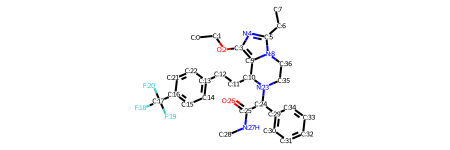

将第27个原子修改为C的分子： CCOc1nc(CC)n2c1C(CCc1ccc(C(F)(F)F)cc1)N(C(C(=O)CC)c1ccccc1)CC2


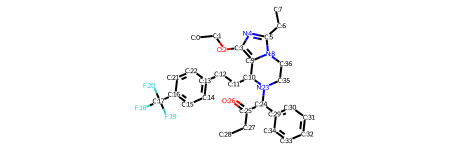

高活性分子： CCc1nc(SC)c2n1CCN(C(C(=O)NC)c1ccccc1)C2CCc1ccc(C(F)(F)F)cc1


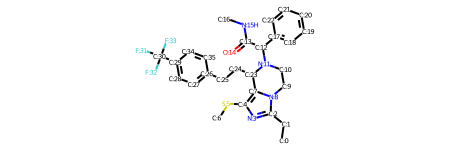

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.985, 'N': 0.0, 'O': 0.0, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#14(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.982, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#14(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.973, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.005, 'As': 0.0, 'Se': 0.0, 'Br': 0.008, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------

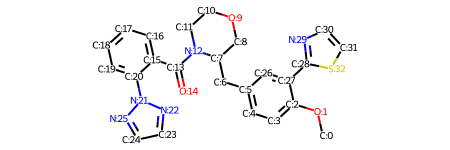

将第12个原子修改为C的分子： COc1ccc(CC2COCCC2C(=O)c2ccccc2-n2nccn2)cc1-c1nccs1


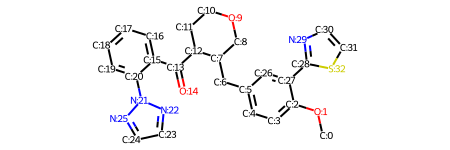

高活性分子： COc1ccc(CC2COCCN2C(=O)c2ccccc2-n2nccn2)cc1-c1cccs1


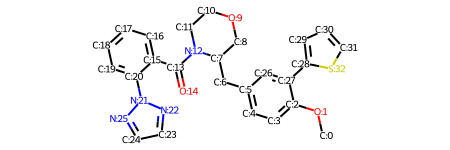

atom#0(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.007, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.001, 'C': 0.839, 'N': 0.0, 'O': 0.0, 'F': 0.109, 'Si': 0.001, 'P': 0.001, 'S': 0.002, 'Cl': 0.002, 'As': 0.001, 'Se': 0.001, 'Br': 0.041, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.002} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.001, 'C': 0.0, 'N': 0.004, 'O': 0.959, 'F': 0.007, 'Si': 0.001, 'P': 0.001, 'S': 0.001, 'Cl': 0.01, 'As': 0.001, 'Se': 0.001, 'Br': 0.012, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.002} 
----------------------------------------------------------------------

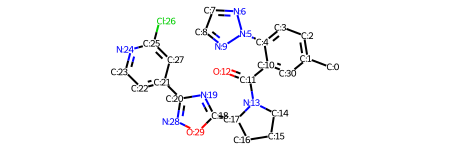

将第0个原子修改为F的分子： O=C(c1cc(F)ccc1-n1nccn1)N1CCCC1c1nc(-c2ccnc(Cl)c2)no1


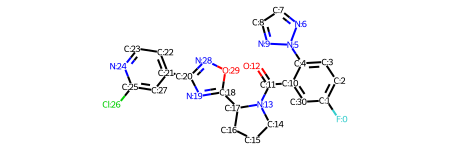

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCCC2c2nc(-c3cccc(Cl)c3)no2)c1


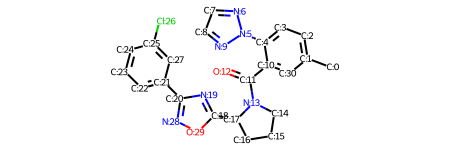

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.983, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.007, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.983, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.007, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom

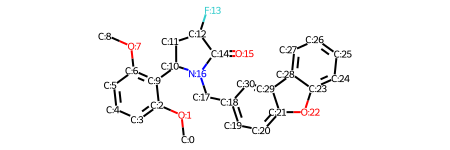

将第13个原子修改为C的分子： COc1cccc(OC)c1C1CC(C)C(=O)N1Cc1ccc2oc3ccccc3c2c1


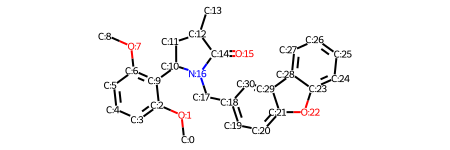

高活性分子： COc1cccc(OC)c1C1CC(O)C(=O)N1Cc1ccc2oc3ccccc3c2c1


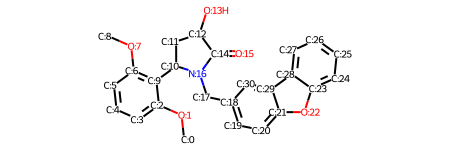

atom#0(f): {'B': 0.0, 'C': 0.986, 'N': 0.0, 'O': 0.0, 'F': 0.007, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.955, 'N': 0.0, 'O': 0.0, 'F': 0.029, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.012, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.982, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.977, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.007, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
-------------------------------------------------------------------------------------------------------

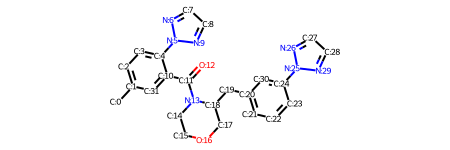

将第13个原子修改为C的分子： Cc1ccc(-n2nccn2)c(C(=O)C2CCOCC2Cc2cccc(-n3nccn3)c2)c1


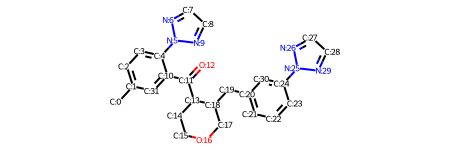

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCCCC2Cc2cccc(-n3nccn3)c2)c1


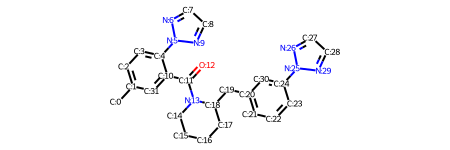

atom#0(f): {'B': 0.0, 'C': 0.991, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.992, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.001, 'C': 0.002, 'N': 0.004, 'O': 0.928, 'F': 0.012, 'Si': 0.001, 'P': 0.001, 'S': 0.018, 'Cl': 0.002, 'As': 0.001, 'Se': 0.001, 'Br': 0.021, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.003} 
---------------------------------------------------------------------------------------

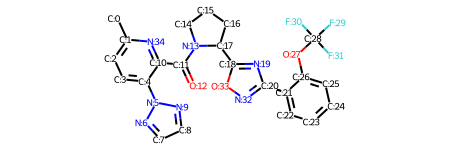

将第31个原子修改为C的分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCCC2c2nc(-c3ccccc3OC(C)(F)F)no2)n1


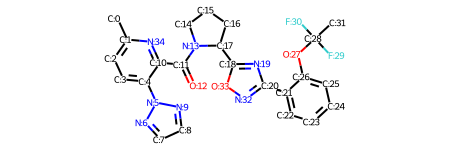

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCCC2c2nc(-c3ccccc3OC(F)(F)F)no2)c1


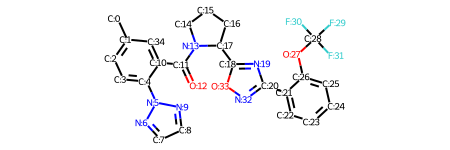

atom#0(f): {'B': 0.0, 'C': 0.982, 'N': 0.0, 'O': 0.0, 'F': 0.01, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.005, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#19(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#19(f+d): {'B': 0.002, 'C': 0.004, 'N': 0.005, 'O': 0.872, 'F': 0.01, 'Si': 0.002, 'P': 0.002, 'S': 0.056, 'Cl': 0.001, 'As': 0.002, 'Se': 0.002, 'Br': 0.031, 'Te': 0.002, 'I': 0.002, 'At': 0.002, 'other': 0.005} 
-----------------------------------------------------------------------------------------

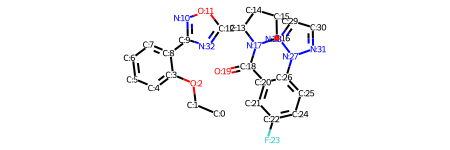

将第23个原子修改为C的分子： CCOc1ccccc1-c1noc(C2CCCN2C(=O)c2cc(C)ccc2-n2nccn2)n1


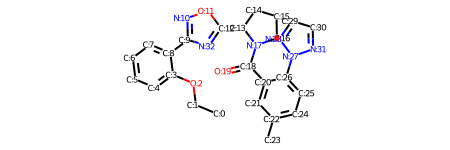

高活性分子： CCOc1ccccc1-c1noc(C2CCCN2C(=O)c2cc(C)ccc2-n2nccn2)n1


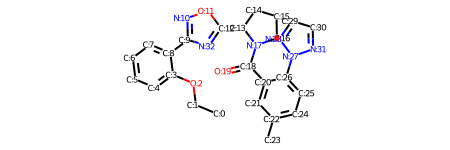

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.978, 'N': 0.0, 'O': 0.0, 'F': 0.01, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.0, 'C': 0.007, 'N': 0.0, 'O': 0.005, 'F': 0.972, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.011, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.0, 'C': 0.005, 'N': 0.0, 'O': 0.014, 'F': 0.919, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.024, 'As': 0.0, 'Se': 0.0, 'Br': 0.032, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
at

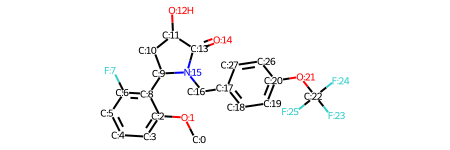

将第10个原子修改为O的分子： COc1cccc(F)c1C1OC(O)C(=O)N1Cc1ccc(OC(F)(F)F)cc1


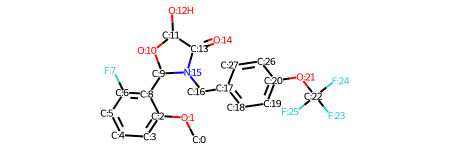

高活性分子： COc1cccc(F)c1C1CC(F)C(=O)N1Cc1ccc(OC(F)(F)F)cc1


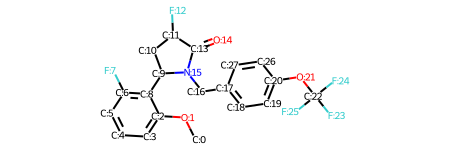

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.0, 'C': 0.007, 'N': 0.0, 'O': 0.005, 'F': 0.972, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.011, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.0, 'C': 0.007, 'N': 0.0, 'O': 0.005, 'F': 0.972, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.011, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom

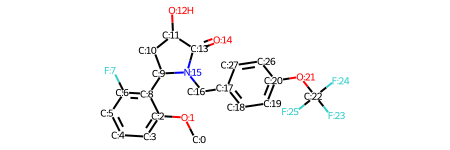

将第15个原子修改为C的分子： COc1cccc(F)c1C1CC(O)C(=O)C1Cc1ccc(OC(F)(F)F)cc1


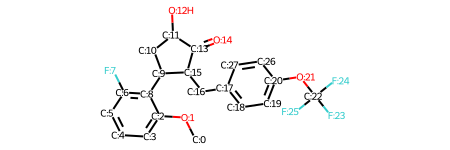

高活性分子： COc1cccc(F)c1C1CC(Cl)C(=O)N1Cc1ccc(OC(F)(F)F)cc1


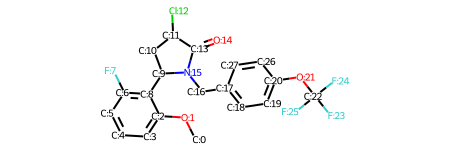

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#13(f)

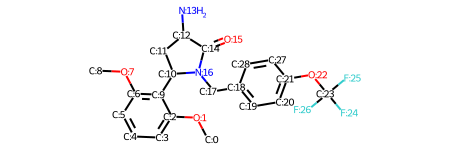

将第16个原子修改为C的分子： COc1cccc(OC)c1C1CC(N)C(=O)C1Cc1ccc(OC(F)(F)F)cc1


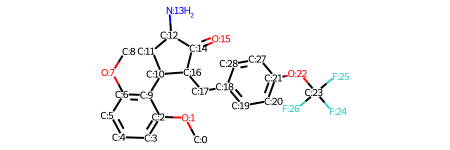

高活性分子： COc1cccc(OC)c1C1CC(Cl)C(=O)N1Cc1ccc(OC(F)(F)F)cc1


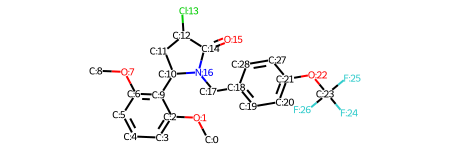

congratulations: [1] [10]
atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.986, 'N': 0.0, 'O': 0.0, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.986, 'N': 0.0, 'O': 0.0, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
---------------------------------------------------------------------------------------

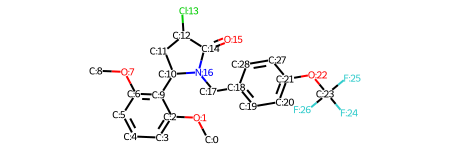

将第16个原子修改为C的分子： COc1cccc(OC)c1C1CC(Cl)C(=O)C1Cc1ccc(OC(F)(F)F)cc1


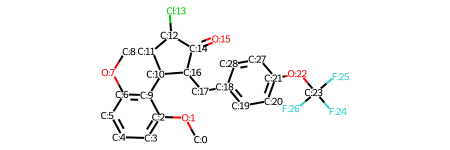

高活性分子： COc1cccc(OC)c1C1CC(F)C(=O)N1Cc1ccc(OC(F)(F)F)cc1


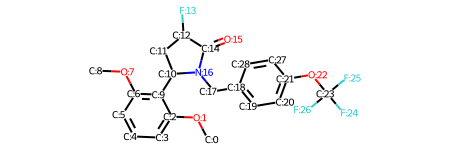

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#5(f): {'B': 0.0, 'C': 0.01, 'N': 0.0, 'O': 0.005, 'F': 0.963, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.005, 'As': 0.0, 'Se': 0.0, 'Br': 0.014, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#5(f+d): {'B': 0.0, 'C': 0.007, 'N': 0.0, 'O': 0.006, 'F': 0.956, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.01, 'As': 0.0, 'Se': 0.0, 'Br': 0.019, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#

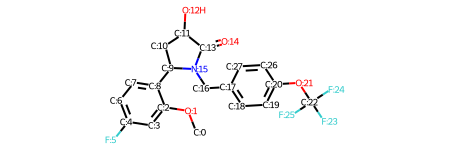

将第15个原子修改为C的分子： COc1cc(F)ccc1C1CC(O)C(=O)C1Cc1ccc(OC(F)(F)F)cc1


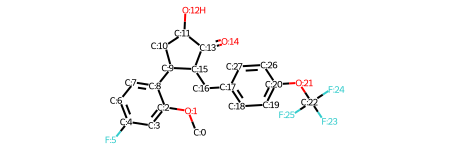

高活性分子： COc1cc(F)ccc1C1CC(F)C(=O)N1Cc1ccc(OC(F)(F)F)cc1


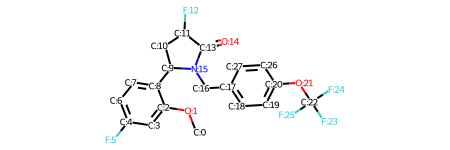

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.986, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.003, 'O': 0.98, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#15(f): {'B': 0.0, 'C': 0.0, 'N': 0.017, 'O': 0.007, 'F': 0.008, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.945, 'As': 0.0, 'Se': 0.0, 'Br': 0.02, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#15(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.018, 'O': 0.009, 'F': 0.007, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.944, 'As': 0.0, 'Se': 0.0, 'Br': 0.019, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
---------------------------------------------------------------------------------------------------

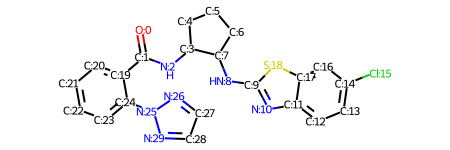

将第8个原子修改为C的分子： O=C(NC1CCCC1Cc1nc2ccc(Cl)cc2s1)c1ccccc1-n1nccn1


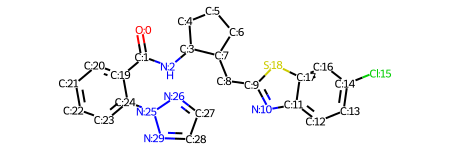

高活性分子： O=C(NC1CCCC1Nc1nc2ccc(F)cc2s1)c1ccccc1-n1nccn1


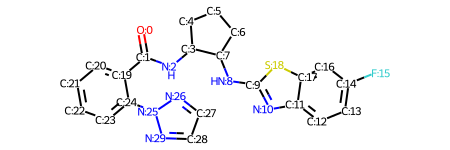

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.989, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.005, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.989, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.005, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#15(

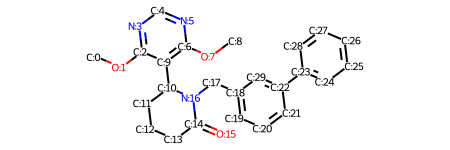

将第1个原子修改为S的分子： COc1ncnc(SC)c1C1CCCC(=O)N1Cc1cccc(-c2ccccc2)c1


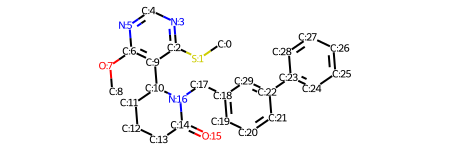

高活性分子： COc1ccnc(OC)c1C1CCCC(=O)N1Cc1cccc(-c2ccccc2)c1


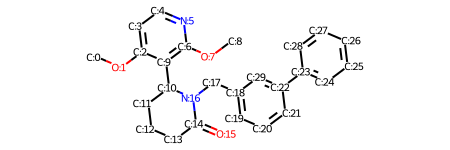

atom#0(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.989, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.0, 'C': 0.989, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#17(f)

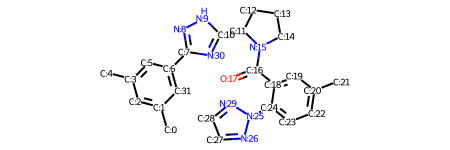

将第25个原子修改为C的分子： Cc1cc(C)cc(-c2n[nH]c(C3CCCN3C(=O)c3cc(C)ccc3C3NCCN3)n2)c1


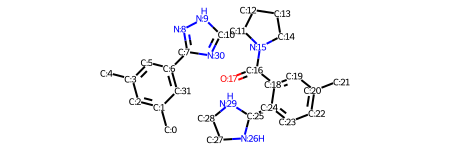

高活性分子： Cc1cc(C)cc(-c2noc(C3CCCN3C(=O)c3cc(C)ccc3-n3nccn3)n2)c1


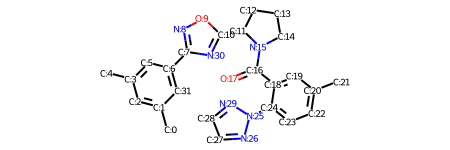

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#1

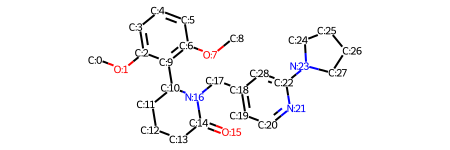

将第21个原子修改为C的分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1cccc(N2CCCC2)c1


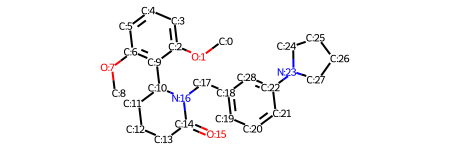

高活性分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1cccc(N2CCCC2)c1


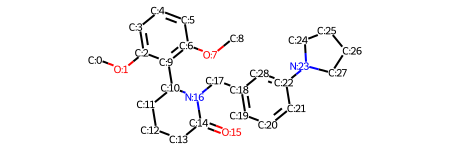

atom#0(f): {'B': 0.0, 'C': 0.992, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.001, 'C': 0.88, 'N': 0.0, 'O': 0.0, 'F': 0.064, 'Si': 0.001, 'P': 0.001, 'S': 0.004, 'Cl': 0.002, 'As': 0.001, 'Se': 0.001, 'Br': 0.043, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.002} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.982, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.001, 'C': 0.0, 'N': 0.005, 'O': 0.948, 'F': 0.008, 'Si': 0.001, 'P': 0.001, 'S': 0.002, 'Cl': 0.014, 'As': 0.001, 'Se': 0.001, 'Br': 0.015, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.003} 
----------------------------------------------------------------------

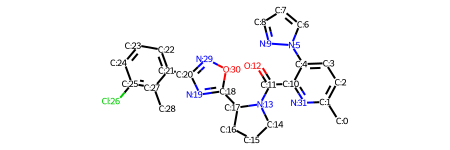

将第28个原子修改为F的分子： Cc1ccc(-n2cccn2)c(C(=O)N2CCCC2c2nc(-c3cccc(Cl)c3F)no2)n1


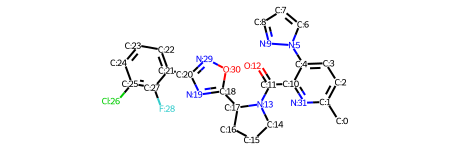

高活性分子： Cc1ccc(-n2cccn2)c(C(=O)N2CCCC2c2nc(-c3cccc(Cl)c3C)no2)c1


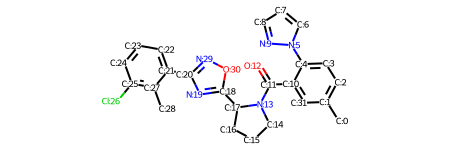

atom#0(f): {'B': 0.0, 'C': 0.991, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.993, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#13(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.982, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#13(f+d): {'B': 0.001, 'C': 0.0, 'N': 0.002, 'O': 0.969, 'F': 0.006, 'Si': 0.001, 'P': 0.001, 'S': 0.006, 'Cl': 0.002, 'As': 0.001, 'Se': 0.001, 'Br': 0.01, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.001} 
------------------------------------------------------------------------------------------

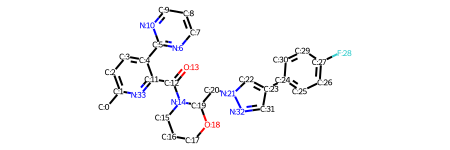

将第28个原子修改为C的分子： Cc1ccc(-c2cnn(CC3OCCCN3C(=O)c3nc(C)ccc3-c3ncccn3)c2)cc1


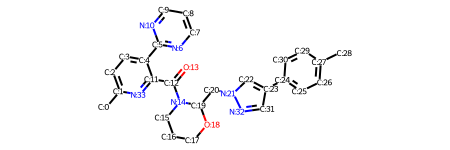

高活性分子： Cc1ccc(-c2ncccn2)c(C(=O)N2CCCOC2Cn2cc(-c3ccc(F)cc3)cn2)c1


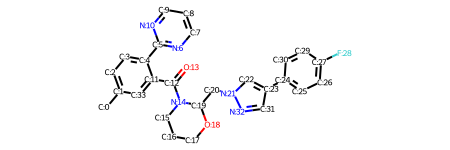

atom#0(f): {'B': 0.0, 'C': 0.989, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.989, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.98, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.003, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#6(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.98, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.003, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
---------------------------------------------------------------------------------------------------------

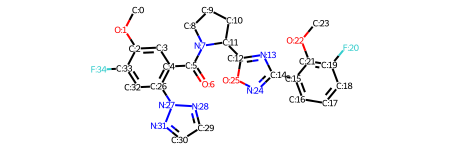

将第7个原子修改为C的分子： COc1cc(C(=O)C2CCCC2c2nc(-c3cccc(F)c3OC)no2)c(-n2nccn2)cc1F


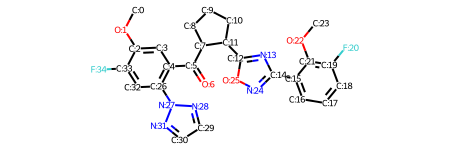

高活性分子： COc1cc(C(=O)N2CCCC2c2nc(-c3cccc(F)c3OC)no2)c(-n2nccn2)cc1Cl


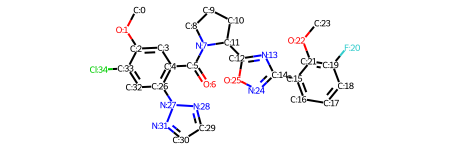

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#13(f)

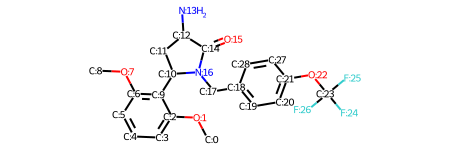

将第16个原子修改为C的分子： COc1cccc(OC)c1C1CC(N)C(=O)C1Cc1ccc(OC(F)(F)F)cc1


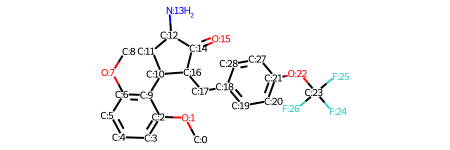

高活性分子： COc1cccc(OC)c1C1CC(O)C(=O)N1Cc1ccc(OC(F)(F)F)cc1


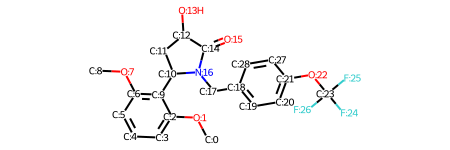

congratulations: [2] [20]
atom#0(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.98, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.003, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.002, 'C': 0.004, 'N': 0.006, 'O': 0.871, 'F': 0.012, 'Si': 0.002, 'P': 0.002, 'S': 0.05, 'Cl': 0.002, 'As': 0.002, 'Se': 0.002, 'Br': 0.033, 'Te': 0.002, 'I': 0.002, 'At': 0.002, 'other': 0.005} 
----------------------------------------------------------------

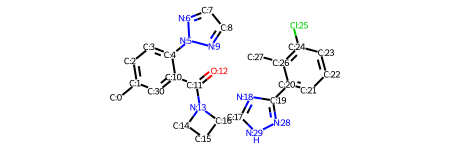

将第29个原子修改为C的分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCC2C2CNC(c3cccc(Cl)c3C)N2)c1


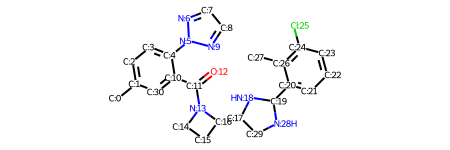

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCC2c2nc(-c3cccc(Cl)c3C)no2)c1


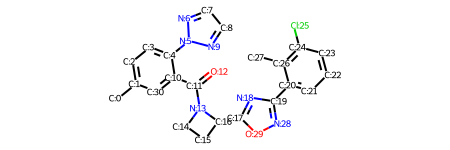

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.992, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.012, 'N': 0.0, 'O': 0.005, 'F': 0.96, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.006, 'As': 0.0, 'Se': 0.0, 'Br': 0.016, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.001, 'C': 0.348, 'N': 0.0, 'O': 0.006, 'F': 0.585, 'Si': 0.001, 'P': 0.001, 'S': 0.002, 'Cl': 0.003, 'As': 0.001, 'Se': 0.001, 'Br': 0.047, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.002} 
-------------------------------------------------------------------------------------------------

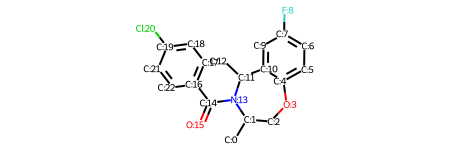

将第8个原子修改为C的分子： Cc1ccc2c(c1)C(C)N(C(=O)c1ccc(Cl)cc1)C(C)CO2


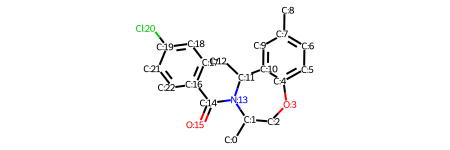

高活性分子： Cc1ccc2c(c1)C(C)N(C(=O)c1ccc(Cl)cc1)C(C)CO2


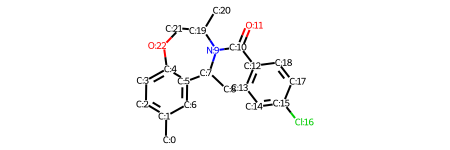

atom#0(f): {'B': 0.0, 'C': 0.992, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.993, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.982, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.975, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.004, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.008, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
---------------------------------------------------------------------------------------------------------

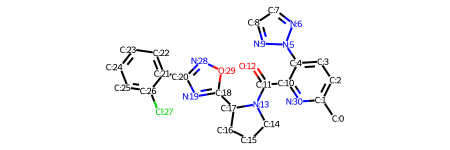

将第13个原子修改为C的分子： Cc1ccc(-n2nccn2)c(C(=O)C2CCCC2c2nc(-c3ccccc3Cl)no2)n1


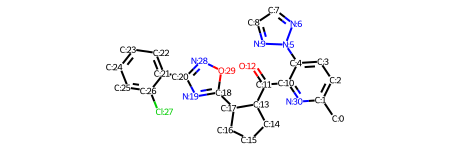

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCCC2c2nc(-c3ccccc3Cl)no2)c1


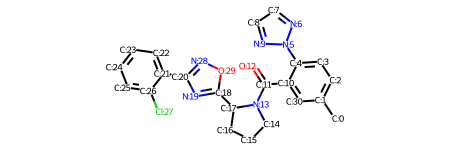

atom#0(f): {'B': 0.0, 'C': 0.992, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.945, 'N': 0.0, 'O': 0.0, 'F': 0.025, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.023, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.982, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.001, 'C': 0.0, 'N': 0.004, 'O': 0.962, 'F': 0.006, 'Si': 0.001, 'P': 0.001, 'S': 0.001, 'Cl': 0.009, 'As': 0.001, 'Se': 0.001, 'Br': 0.011, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.002} 
-------------------------------------------------------------------------------------

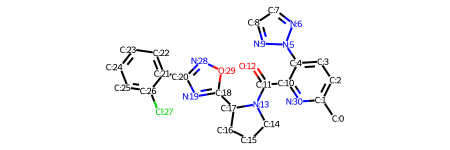

将第15个原子修改为O的分子： Cc1ccc(-n2nccn2)c(C(=O)N2COCC2c2nc(-c3ccccc3Cl)no2)n1


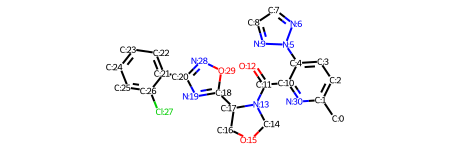

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCCC2c2nc(-c3ccccc3C)no2)c1


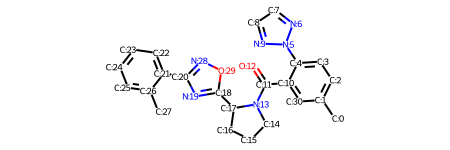

atom#0(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.003, 'C': 0.103, 'N': 0.001, 'O': 0.008, 'F': 0.573, 'Si': 0.003, 'P': 0.003, 'S': 0.002, 'Cl': 0.075, 'As': 0.003, 'Se': 0.003, 'Br': 0.203, 'Te': 0.003, 'I': 0.003, 'At': 0.003, 'other': 0.012} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.98, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.003, 'C': 0.0, 'N': 0.041, 'O': 0.713, 'F': 0.014, 'Si': 0.003, 'P': 0.003, 'S': 0.003, 'Cl': 0.131, 'As': 0.003, 'Se': 0.003, 'Br': 0.06, 'Te': 0.003, 'I': 0.003, 'At': 0.003, 'other': 0.014} 
-------------------------------------------------------------------

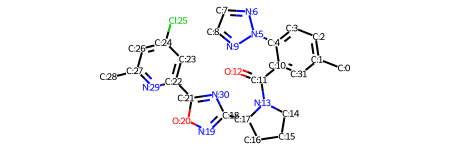

将第0个原子修改为F的分子： Cc1cc(Cl)cc(-c2nc(C3CCCN3C(=O)c3cc(F)ccc3-n3nccn3)no2)n1


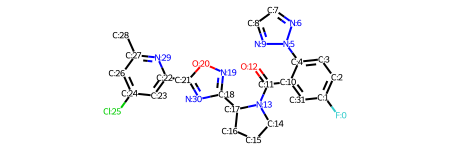

高活性分子： COc1cc(Cl)cc(-c2nc(C3CCCN3C(=O)c3cc(C)ccc3-n3nccn3)no2)n1


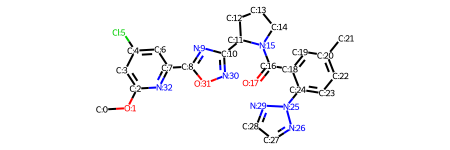

atom#0(f): {'B': 0.0, 'C': 0.985, 'N': 0.0, 'O': 0.0, 'F': 0.008, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.985, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.004, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#13(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#13(f+d): {'B': 0.005, 'C': 0.025, 'N': 0.009, 'O': 0.61, 'F': 0.015, 'Si': 0.005, 'P': 0.005, 'S': 0.22, 'Cl': 0.002, 'As': 0.005, 'Se': 0.005, 'Br': 0.066, 'Te': 0.005, 'I': 0.005, 'At': 0.005, 'other': 0.014} 
-----------------------------------------------------------------------------------------

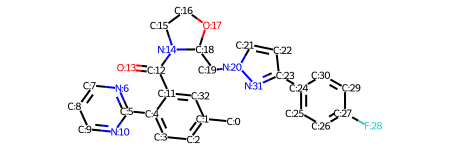

将第28个原子修改为C的分子： Cc1ccc(-c2ccn(CC3OCCN3C(=O)c3cc(C)ccc3-c3ncccn3)n2)cc1


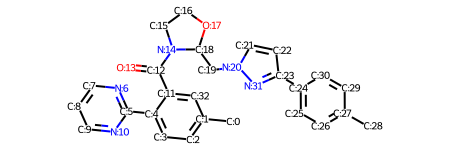

高活性分子： Cc1ccc(-c2ncccn2)c(C(=O)N2CCOC2Cn2ccc(-c3ccc(F)cn3)n2)c1


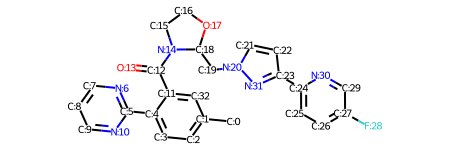

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#9(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#9(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#13(f)

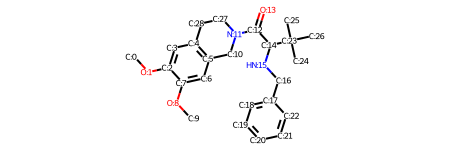

将第11个原子修改为C的分子： COc1cc2c(cc1OC)CC(C(=O)C(NCc1ccccc1)C(C)(C)C)CC2


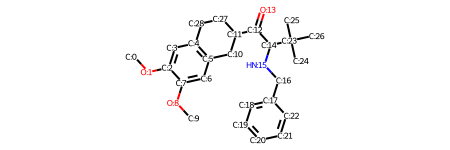

高活性分子： COc1cc2c(cc1OC)CN(C(=O)C(NCc1cccnc1)C(C)(C)C)CC2


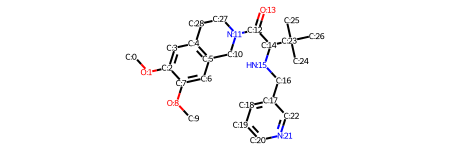

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.979, 'N': 0.0, 'O': 0.0, 'F': 0.009, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.979, 'N': 0.0, 'O': 0.0, 'F': 0.009, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#15(

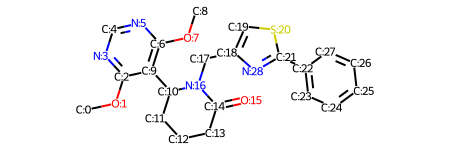

将第12个原子修改为O的分子： COc1ncnc(OC)c1C1COCC(=O)N1Cc1csc(-c2ccccc2)n1


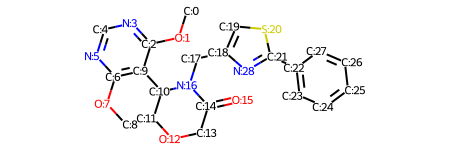

高活性分子： COc1ccnc(OC)c1C1CCCC(=O)N1Cc1csc(-c2ccccc2)n1


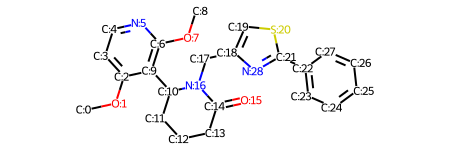

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#1

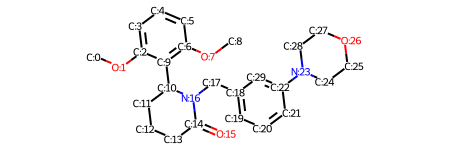

将第16个原子修改为C的分子： COc1cccc(OC)c1C1CCCC(=O)C1Cc1cccc(N2CCOCC2)c1


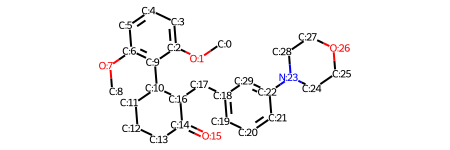

高活性分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1cccc(N2CCCCC2)c1


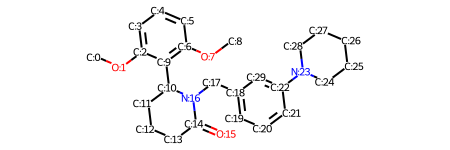

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#9(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#9(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#13(f)

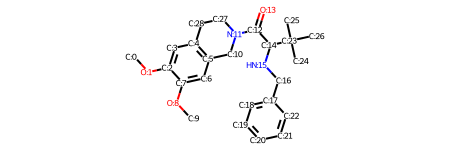

将第11个原子修改为C的分子： COc1cc2c(cc1OC)CC(C(=O)C(NCc1ccccc1)C(C)(C)C)CC2


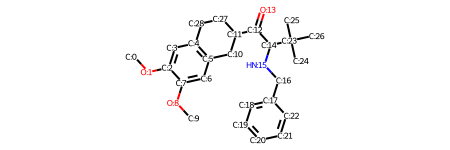

高活性分子： COc1cc2c(cc1OC)CN(C(=O)C(NCc1ccncc1)C(C)(C)C)CC2


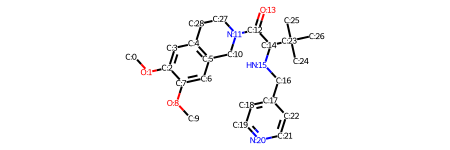

congratulations: [3] [30]
atom#0(f): {'B': 0.0, 'C': 0.982, 'N': 0.0, 'O': 0.0, 'F': 0.01, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.982, 'N': 0.0, 'O': 0.0, 'F': 0.01, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#19(f): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#19(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
---------------------------------------------------------------------------------

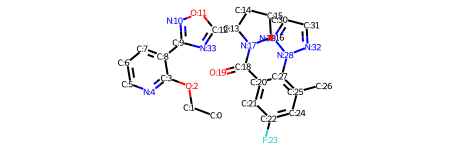

将第4个原子修改为C的分子： CCOc1ccccc1-c1noc(C2CCCN2C(=O)c2cc(F)cc(C)c2-n2nccn2)n1


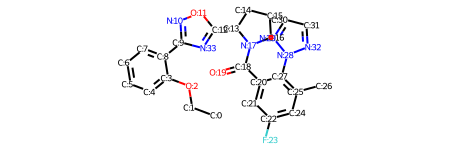

高活性分子： CCOc1ncccc1-c1noc(C2CCCN2C(=O)c2cc(C)cc(C)c2-n2nccn2)n1


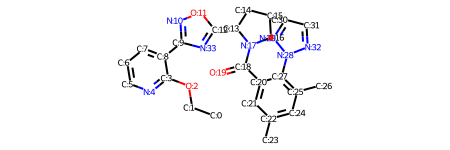

atom#0(f): {'B': 0.0, 'C': 0.978, 'N': 0.0, 'O': 0.0, 'F': 0.014, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.001, 'C': 0.205, 'N': 0.0, 'O': 0.004, 'F': 0.719, 'Si': 0.001, 'P': 0.001, 'S': 0.001, 'Cl': 0.005, 'As': 0.001, 'Se': 0.001, 'Br': 0.056, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.003} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.007, 'N': 0.0, 'O': 0.005, 'F': 0.971, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.011, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.001, 'C': 0.005, 'N': 0.0, 'O': 0.036, 'F': 0.757, 'Si': 0.001, 'P': 0.001, 'S': 0.0, 'Cl': 0.111, 'As': 0.001, 'Se': 0.001, 'Br': 0.078, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.003} 
---------------------------------------------------------------------------

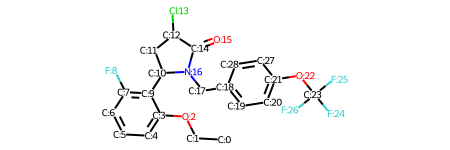

将第0个原子修改为F的分子： O=C1C(Cl)CC(c2c(F)cccc2OCF)N1Cc1ccc(OC(F)(F)F)cc1


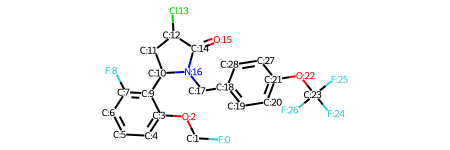

高活性分子： CCOc1cccc(F)c1C1CC(F)C(=O)N1Cc1ccc(OC(F)(F)F)cc1


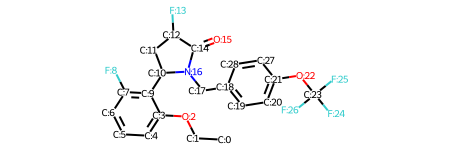

atom#0(f): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.951, 'N': 0.0, 'O': 0.0, 'F': 0.031, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.014, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.974, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.008, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
-------------------------------------------------------------------------------------------------------

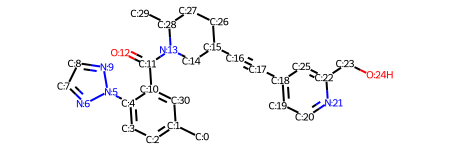

将第13个原子修改为C的分子： Cc1ccc(-n2nccn2)c(C(=O)C2CC(C#Cc3ccnc(CO)c3)CCC2C)c1


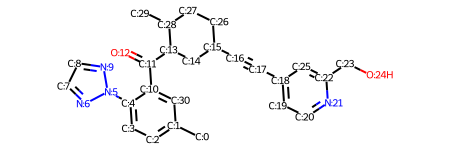

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CC(C#Cc3cccc(CO)c3)CCC2C)c1


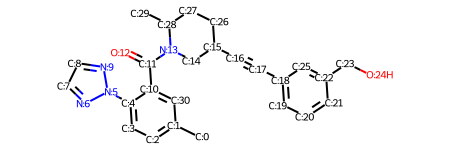

atom#0(f): {'B': 0.0, 'C': 0.98, 'N': 0.0, 'O': 0.0, 'F': 0.012, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.98, 'N': 0.0, 'O': 0.0, 'F': 0.012, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#5(f): {'B': 0.0, 'C': 0.0, 'N': 0.023, 'O': 0.009, 'F': 0.008, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.938, 'As': 0.0, 'Se': 0.0, 'Br': 0.019, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#5(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.023, 'O': 0.009, 'F': 0.008, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.938, 'As': 0.0, 'Se': 0.0, 'Br': 0.019, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom

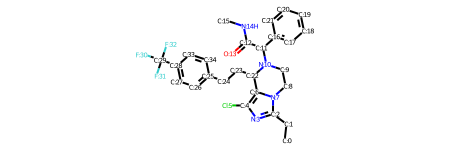

将第14个原子修改为C的分子： CCC(=O)C(c1ccccc1)N1CCn2c(CC)nc(Cl)c2C1CCc1ccc(C(F)(F)F)cc1


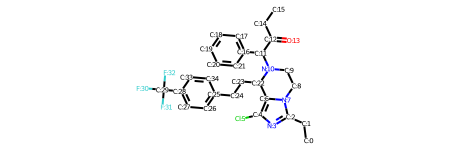

高活性分子： CCc1nc(C#N)c2n1CCN(C(C(=O)NC)c1ccccc1)C2CCc1ccc(C(F)(F)F)cc1


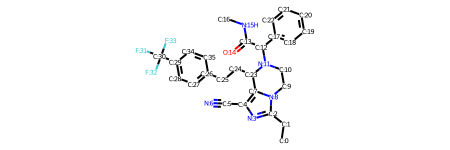

atom#0(f): {'B': 0.0, 'C': 0.98, 'N': 0.0, 'O': 0.0, 'F': 0.012, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.001, 'C': 0.272, 'N': 0.0, 'O': 0.004, 'F': 0.643, 'Si': 0.001, 'P': 0.001, 'S': 0.001, 'Cl': 0.005, 'As': 0.001, 'Se': 0.001, 'Br': 0.062, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.003} 
------------------------------------------------------------------------------------------------------------
atom#5(f): {'B': 0.0, 'C': 0.0, 'N': 0.023, 'O': 0.009, 'F': 0.008, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.938, 'As': 0.0, 'Se': 0.0, 'Br': 0.019, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#5(f+d): {'B': 0.001, 'C': 0.0, 'N': 0.035, 'O': 0.017, 'F': 0.007, 'Si': 0.001, 'P': 0.001, 'S': 0.0, 'Cl': 0.911, 'As': 0.001, 'Se': 0.001, 'Br': 0.024, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.001} 
--------------------------------------------------------------------------

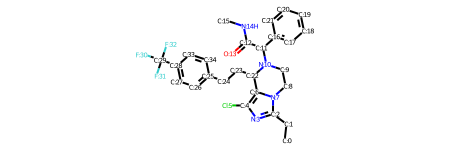

将第0个原子修改为F的分子： CNC(=O)C(c1ccccc1)N1CCn2c(CF)nc(Cl)c2C1CCc1ccc(C(F)(F)F)cc1


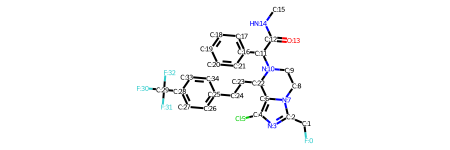

高活性分子： CCc1nc(Cl)c2n1CCN(C(C(=O)NC)c1ccccc1)C2COc1ccc(C(F)(F)F)cc1


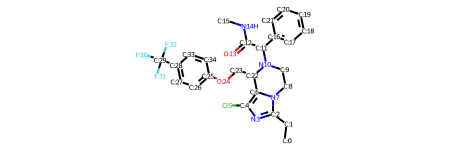

atom#0(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.007, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.002, 'C': 0.003, 'N': 0.005, 'O': 0.894, 'F': 0.011, 'Si': 0.002, 'P': 0.002, 'S': 0.039, 'Cl': 0.002, 'As': 0.002, 'Se': 0.002, 'Br': 0.027, 'Te': 0.002, 'I': 0.002, 'At': 0.002, 'other': 0.004} 
----------------------------------------------------------------------------------------

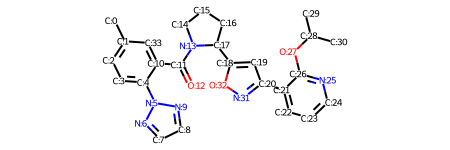

将第5个原子修改为C的分子： Cc1ccc(C2NCCN2)c(C(=O)N2CCCC2c2cc(-c3cccnc3OC(C)C)no2)c1


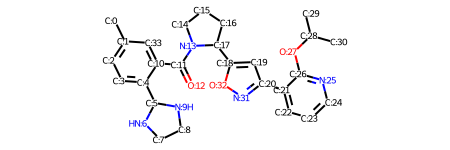

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCCC2c2nc(-c3cccnc3OC(C)C)no2)c1


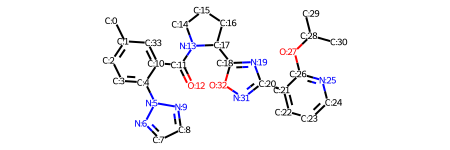

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.986, 'N': 0.0, 'O': 0.0, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.986, 'N': 0.0, 'O': 0.0, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom

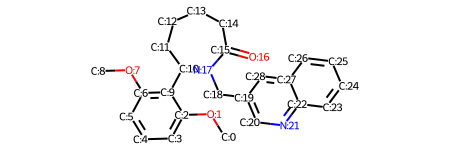

将第17个原子修改为C的分子： COc1cccc(OC)c1C1CCCCC(=O)C1Cc1cnc2ccccc2c1


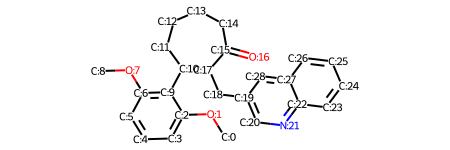

高活性分子： COc1cccc(OC)c1C1CCCCC(=O)N1Cc1ccc2ccccc2c1


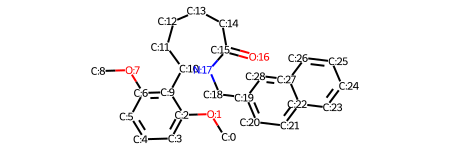

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.972, 'N': 0.0, 'O': 0.0, 'F': 0.012, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.008, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.002} 
------------------------------------------------------------------------------------------------------------
atom#18(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.982, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#18(f+d): {'B': 0.001, 'C': 0.0, 'N': 0.004, 'O': 0.954, 'F': 0.008, 'Si': 0.001, 'P': 0.001, 'S': 0.002, 'Cl': 0.011, 'As': 0.001, 'Se': 0.001, 'Br': 0.013, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.002} 
--------------------------------------------------------------------------------------

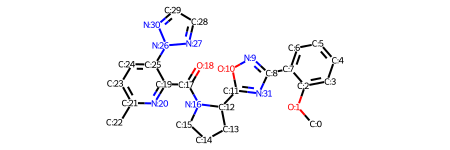

将第22个原子修改为F的分子： COc1ccccc1-c1noc(C2CCCN2C(=O)c2nc(F)ccc2-n2nccn2)n1


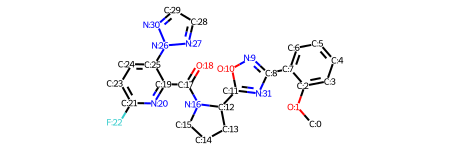

高活性分子： COc1ccccc1-c1noc(C2CCCN2C(=O)c2cc(C)ccc2-n2nccn2)n1


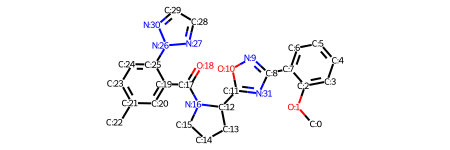

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.984, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.007, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.984, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.007, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom

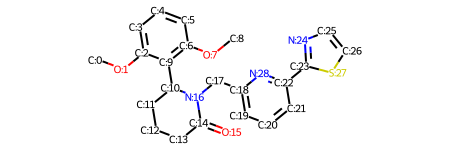

将第28个原子修改为C的分子： COc1cccc(OC)c1C1CCCC(=O)N1CC1CCCC(c2nccs2)C1


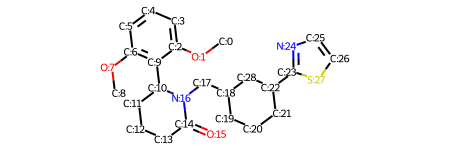

高活性分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1cccc(-c2nccs2)c1


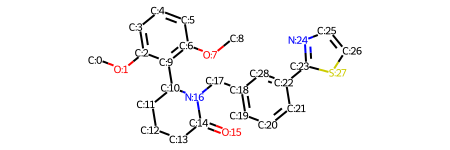

atom#0(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.007, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.007, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
---------------------------------------------------------------------------------------------------------

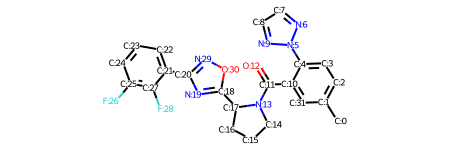

将第13个原子修改为C的分子： Cc1ccc(-n2nccn2)c(C(=O)C2CCCC2c2nc(-c3cccc(F)c3F)no2)c1


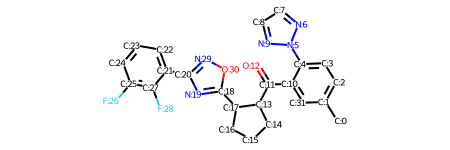

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCCC2c2nc(-c3cccc(F)c3C)no2)c1


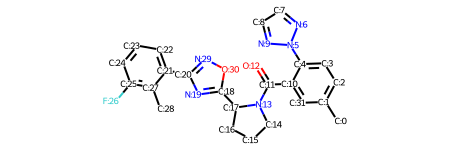

congratulations: [3] [40]
atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
-----------------------------------------------------------------------------------------

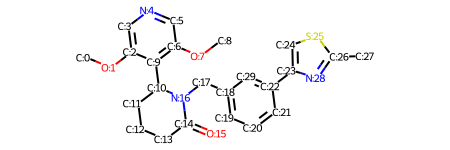

将第4个原子修改为C的分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1cccc(-c2csc(C)n2)c1


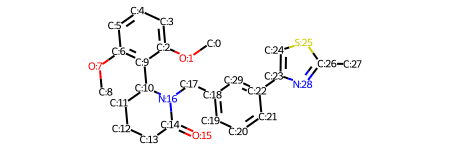

高活性分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1cccc(-c2csc(C)n2)c1


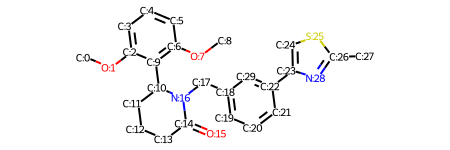

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.981, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.008, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#16(f): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.986, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#16(f+d): {'B': 0.003, 'C': 0.011, 'N': 0.011, 'O': 0.731, 'F': 0.008, 'Si': 0.003, 'P': 0.003, 'S': 0.166, 'Cl': 0.001, 'As': 0.003, 'Se': 0.003, 'Br': 0.042, 'Te': 0.003, 'I': 0.003, 'At': 0.003, 'other': 0.007} 
------------------------------------------------------------------------------------

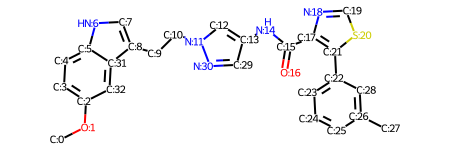

将第6个原子修改为C的分子： COC1CCC2CCC(CCn3cc(NC(=O)c4ncsc4-c4cccc(C)c4)cn3)C2C1


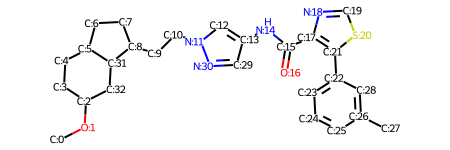

高活性分子： COc1ccc2[nH]cc(CCn3cc(NC(=O)c4ncoc4-c4cccc(C)c4)cn3)c2c1


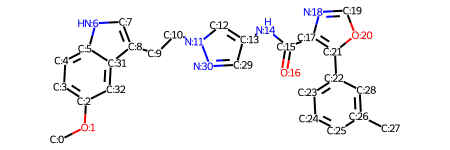

atom#0(f): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.819, 'N': 0.0, 'O': 0.0, 'F': 0.134, 'Si': 0.0, 'P': 0.001, 'S': 0.002, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.037, 'Te': 0.0, 'I': 0.001, 'At': 0.0, 'other': 0.002} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.001, 'C': 0.0, 'N': 0.003, 'O': 0.959, 'F': 0.008, 'Si': 0.001, 'P': 0.001, 'S': 0.002, 'Cl': 0.009, 'As': 0.001, 'Se': 0.001, 'Br': 0.013, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.002} 
---------------------------------------------------------------------------------

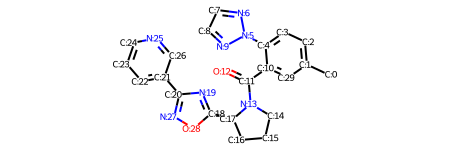

将第0个原子修改为F的分子： O=C(c1cc(F)ccc1-n1nccn1)N1CCCC1c1nc(-c2cccnc2)no1


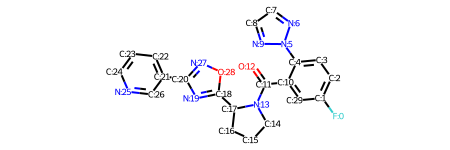

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCCC2c2nc(-c3ccccc3)no2)c1


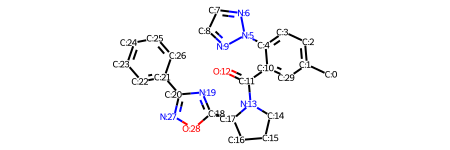

atom#0(f): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
---------------------------------------------------------------------------------------------------------

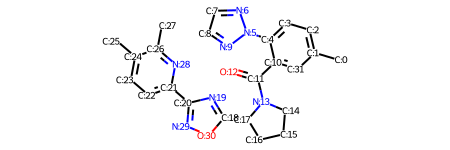

将第13个原子修改为C的分子： Cc1ccc(-n2nccn2)c(C(=O)C2CCCC2c2nc(-c3ccc(C)c(C)n3)no2)c1


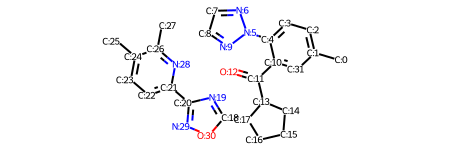

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCCC2c2nc(-c3ccc(C)c(C)c3)no2)c1


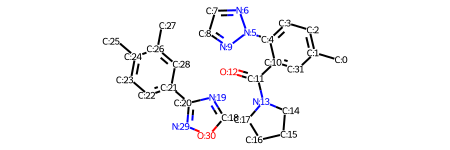

atom#0(f): {'B': 0.0, 'C': 0.991, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.004, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.006, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.991, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#14(f): 

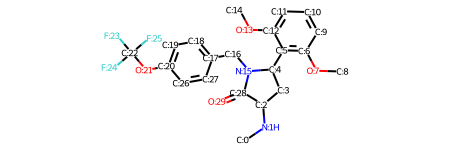

将第24个原子修改为C的分子： CNC1CC(c2c(OC)cccc2OC)N(Cc2ccc(OC(C)(F)F)cc2)C1=O


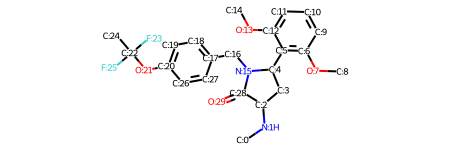

高活性分子： COc1cccc(OC)c1C1CC(OC)C(=O)N1Cc1ccc(OC(F)(F)F)cc1


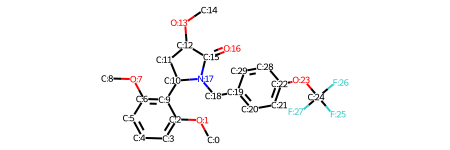

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.984, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.0, 'C': 0.007, 'N': 0.0, 'O': 0.005, 'F': 0.97, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.005, 'As': 0.0, 'Se': 0.0, 'Br': 0.012, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.0, 'C': 0.005, 'N': 0.0, 'O': 0.01, 'F': 0.946, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.013, 'As': 0.0, 'Se': 0.0, 'Br': 0.022, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
ato

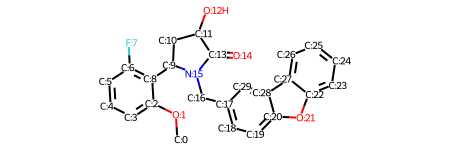

将第15个原子修改为C的分子： COc1cccc(F)c1C1CC(O)C(=O)C1Cc1ccc2oc3ccccc3c2c1


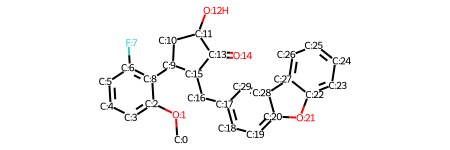

高活性分子： COc1cccc(F)c1C1CC(Cl)C(=O)N1Cc1ccc2oc3ccccc3c2c1


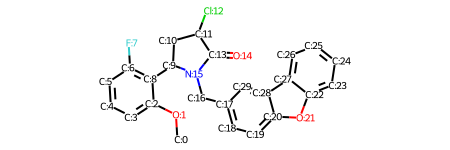

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.989, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.004, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.989, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.004, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#15(

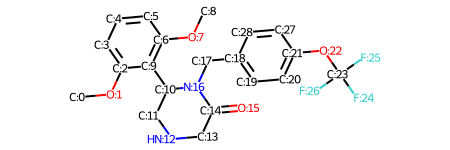

将第25个原子修改为C的分子： COc1cccc(OC)c1C1CNCC(=O)N1Cc1ccc(OC(C)(F)F)cc1


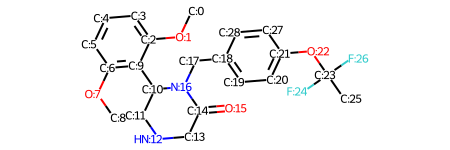

高活性分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1ccc(OC(F)(F)F)cc1


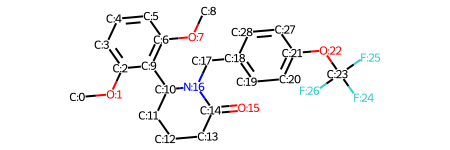

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'

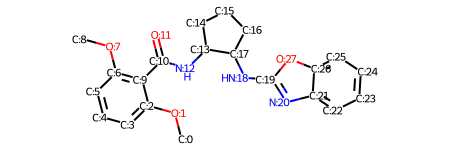

将第18个原子修改为C的分子： COc1cccc(OC)c1C(=O)NC1CCCC1Cc1nc2ccccc2o1


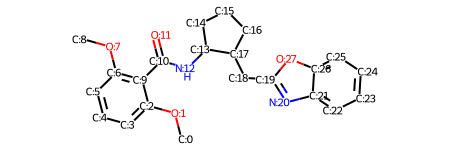

高活性分子： COc1cccc(OC)c1C(=O)NC1CCCC1Nc1nc2ccccc2s1


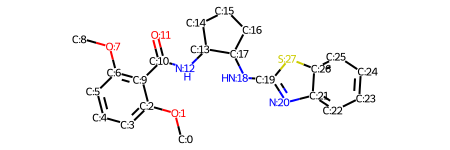

atom#0(f): {'B': 0.0, 'C': 0.985, 'N': 0.0, 'O': 0.0, 'F': 0.008, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.991, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.003, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.973, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.004, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.008, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
---------------------------------------------------------------------------------------------------------

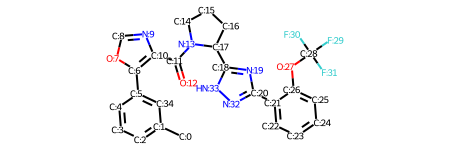

将第13个原子修改为C的分子： Cc1cccc(-c2ocnc2C(=O)C2CCCC2c2nc(-c3ccccc3OC(F)(F)F)n[nH]2)c1


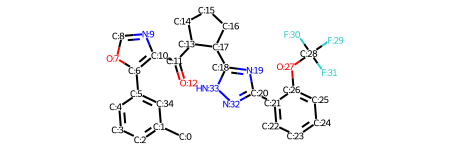

高活性分子： Cc1cccc(-c2ocnc2C(=O)N2CCCC2c2nc(-c3ccccc3OC(F)(F)F)no2)c1


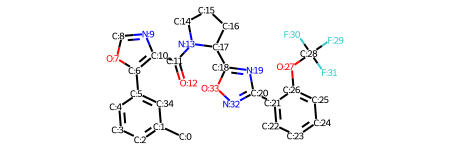

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#11(

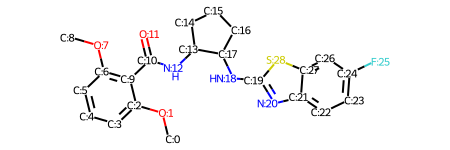

将第18个原子修改为C的分子： COc1cccc(OC)c1C(=O)NC1CCCC1Cc1nc2ccc(F)cc2s1


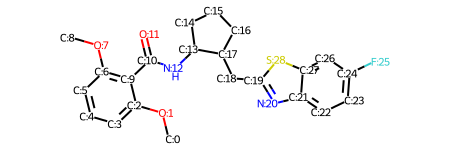

高活性分子： COc1cccc(OC)c1C(=O)NC1CCCC1Nc1nc2ccc(Cl)cc2s1


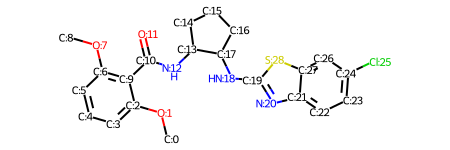

congratulations: [4] [50]
atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
-----------------------------------------------------------------------------------------

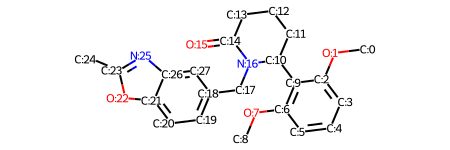

将第16个原子修改为C的分子： COc1cccc(OC)c1C1CCCC(=O)C1Cc1ccc2oc(C)nc2c1


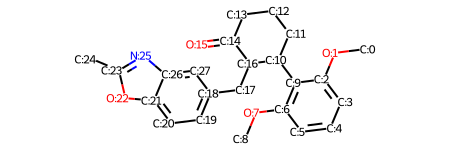

高活性分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1ccc2sc(C)nc2c1


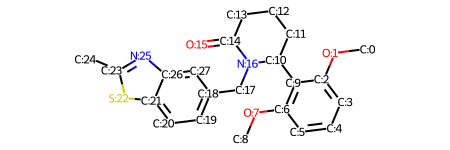

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.967, 'N': 0.0, 'O': 0.0, 'F': 0.016, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.009, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.002} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.967, 'N': 0.0, 'O': 0.0, 'F': 0.016, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.009, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.002} 
------------------------------------------------------------------------------------------------------------
atom#1

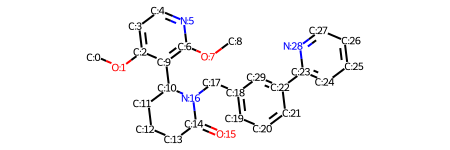

将第12个原子修改为other的分子： COc1ccnc(OC)c1C1C*CC(=O)N1Cc1cccc(-c2ccccn2)c1


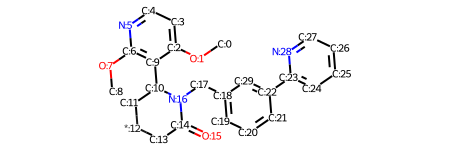

高活性分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1cccc(-c2ccccn2)c1


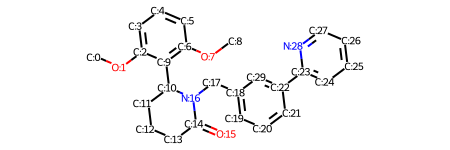

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.986, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.003, 'O': 0.98, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.008, 'N': 0.0, 'O': 0.005, 'F': 0.971, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.01, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.006, 'N': 0.0, 'O': 0.008, 'F': 0.962, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.007, 'As': 0.0, 'Se': 0.0, 'Br': 0.014, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
---------------------------------------------------------------------------------------------------------

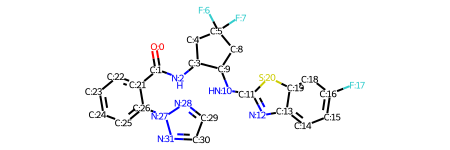

将第10个原子修改为C的分子： O=C(NC1CC(F)(F)CC1Cc1nc2ccc(F)cc2s1)c1ccccc1-n1nccn1


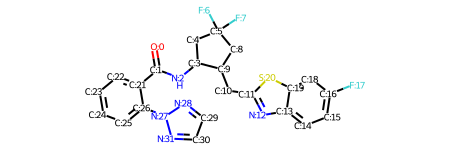

高活性分子： O=C(NC1CC(F)(F)CC1Nc1nc2ccc(Cl)cc2s1)c1ccccc1-n1nccn1


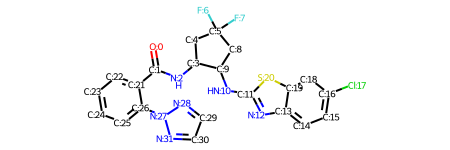

atom#0(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.962, 'N': 0.0, 'O': 0.0, 'F': 0.023, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.01, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.0, 'C': 0.962, 'N': 0.0, 'O': 0.0, 'F': 0.023, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.01, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#6(f

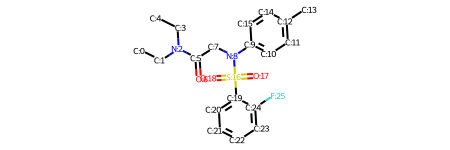

将第2个原子修改为C的分子： CCC(CC)C(=O)CN(c1ccc(C)cc1)S(=O)(=O)c1ccccc1F


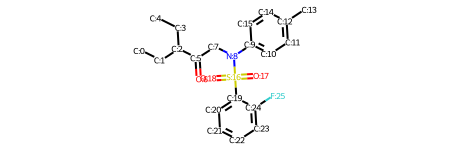

高活性分子： CCN(CC)C(=O)CN(c1ccc(C)cc1)S(=O)(=O)c1ccccc1C


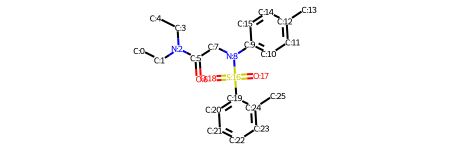

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#9(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#9(f+d): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom

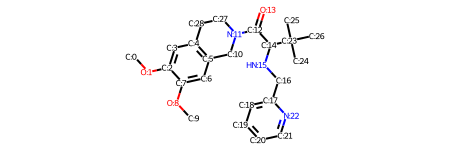

将第11个原子修改为C的分子： COc1cc2c(cc1OC)CC(C(=O)C(NCc1ccccn1)C(C)(C)C)CC2


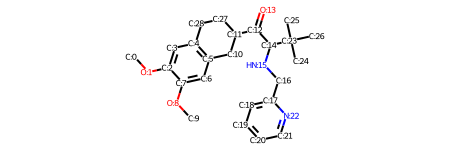

高活性分子： COc1cc2c(cc1OC)CN(C(=O)C(NCc1ccccc1)C(C)(C)C)CC2


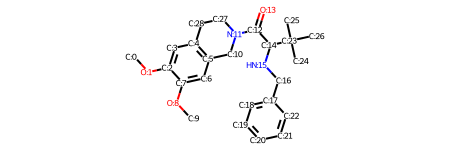

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom

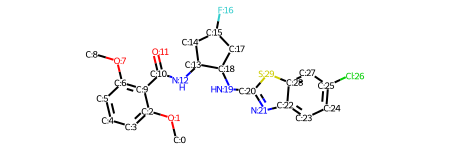

将第19个原子修改为C的分子： COc1cccc(OC)c1C(=O)NC1CC(F)CC1Cc1nc2ccc(Cl)cc2s1


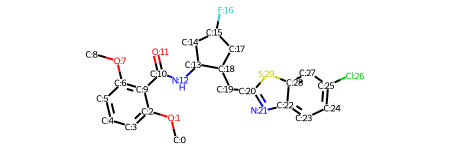

高活性分子： COc1cccc(OC)c1C(=O)NC1CC(O)CC1Nc1nc2ccc(Cl)cc2s1


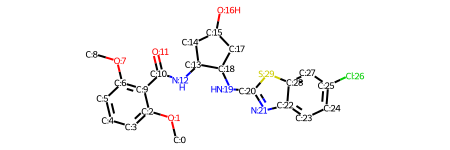

atom#0(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.007, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.96, 'N': 0.0, 'O': 0.0, 'F': 0.024, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.012, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.976, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.007, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
----------------------------------------------------------------------------------------------------------

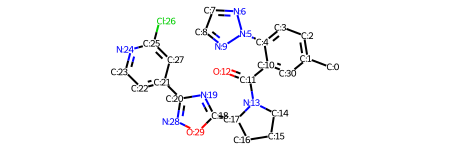

将第13个原子修改为C的分子： Cc1ccc(-n2nccn2)c(C(=O)C2CCCC2c2nc(-c3ccnc(Cl)c3)no2)c1


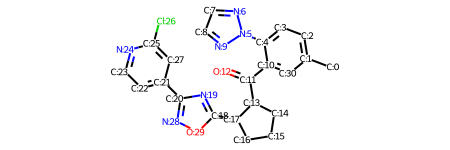

高活性分子： Cc1cccc(-c2noc(C3CCCN3C(=O)c3cc(C)ccc3-n3nccn3)n2)c1


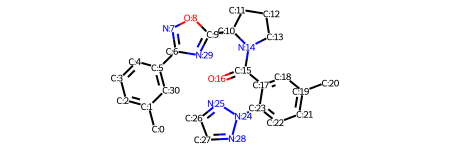

atom#0(f): {'B': 0.0, 'C': 0.986, 'N': 0.0, 'O': 0.0, 'F': 0.008, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.991, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.982, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.979, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.007, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
---------------------------------------------------------------------------------------------------------

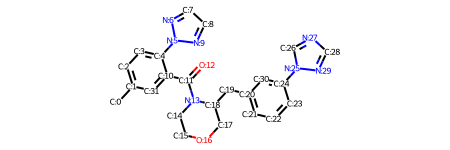

将第27个原子修改为C的分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCOCC2Cc2cccc(-n3cccn3)c2)c1


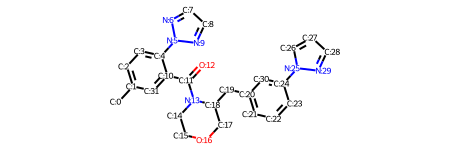

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCOCC2Cc2cccc(-n3cccn3)c2)c1


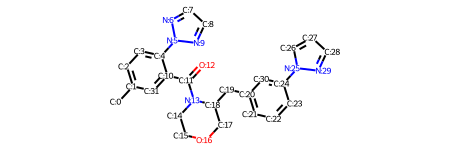

atom#0(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.007, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.992, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.001, 'C': 0.0, 'N': 0.002, 'O': 0.965, 'F': 0.007, 'Si': 0.001, 'P': 0.001, 'S': 0.006, 'Cl': 0.002, 'As': 0.001, 'Se': 0.001, 'Br': 0.011, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.002} 
-----------------------------------------------------------------------------------------

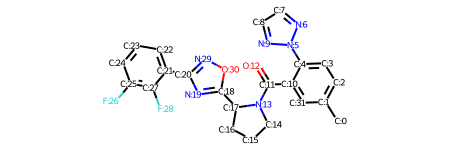

将第13个原子修改为C的分子： Cc1ccc(-n2nccn2)c(C(=O)C2CCCC2c2nc(-c3cccc(F)c3F)no2)c1


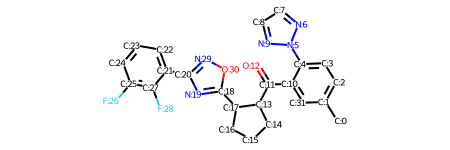

高活性分子： COc1c(F)cccc1-c1noc(C2CCCN2C(=O)c2cc(C)ccc2-n2nccn2)n1


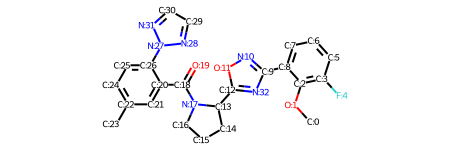

atom#0(f): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.007, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.007, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.98, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.98, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
-----------------------------------------------------------------------------------------------------------

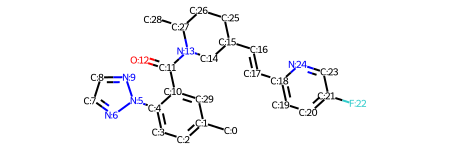

将第24个原子修改为C的分子： Cc1ccc(-n2nccn2)c(C(=O)N2CC(C=Cc3ccc(F)cc3)CCC2C)c1


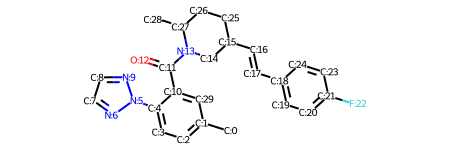

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CC(C#Cc3ccc(F)cn3)CCC2C)c1


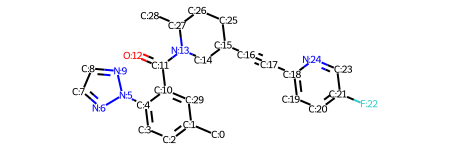

congratulations: [5] [60]
atom#0(f): {'B': 0.0, 'C': 0.981, 'N': 0.0, 'O': 0.0, 'F': 0.01, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.002, 'C': 0.122, 'N': 0.0, 'O': 0.011, 'F': 0.747, 'Si': 0.002, 'P': 0.002, 'S': 0.002, 'Cl': 0.01, 'As': 0.002, 'Se': 0.002, 'Br': 0.089, 'Te': 0.002, 'I': 0.002, 'At': 0.002, 'other': 0.006} 
------------------------------------------------------------------------------------------------------------
atom#5(f): {'B': 0.0, 'C': 0.008, 'N': 0.0, 'O': 0.005, 'F': 0.968, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.005, 'As': 0.0, 'Se': 0.0, 'Br': 0.012, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#5(f+d): {'B': 0.002, 'C': 0.005, 'N': 0.001, 'O': 0.073, 'F': 0.53, 'Si': 0.002, 'P': 0.002, 'S': 0.001, 'Cl': 0.241, 'As': 0.002, 'Se': 0.002, 'Br': 0.124, 'Te': 0.002, 'I': 0.002, 'At': 0.002, 'other': 0.008} 
------------------------------------------------

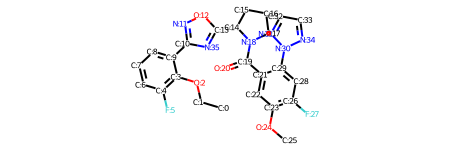

将第0个原子修改为F的分子： COc1cc(C(=O)N2CCCC2c2nc(-c3cccc(F)c3OCF)no2)c(-n2nccn2)cc1F


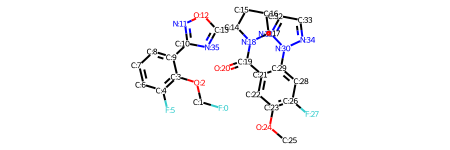

高活性分子： CCOc1c(F)cccc1-c1noc(C2CCCN2C(=O)c2cc(OC)c(C)cc2-n2nccn2)n1


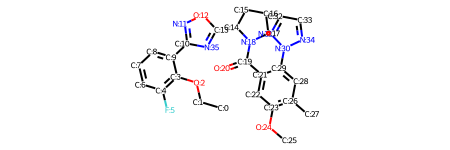

atom#0(f): {'B': 0.0, 'C': 0.993, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.993, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.01, 'N': 0.0, 'O': 0.007, 'F': 0.967, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.003, 'As': 0.0, 'Se': 0.0, 'Br': 0.011, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.001, 'C': 0.276, 'N': 0.0, 'O': 0.011, 'F': 0.657, 'Si': 0.001, 'P': 0.001, 'S': 0.002, 'Cl': 0.002, 'As': 0.001, 'Se': 0.001, 'Br': 0.041, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.002} 
------------------------------------------------------------------------------------------------

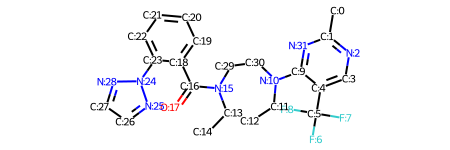

将第6个原子修改为C的分子： Cc1ncc(C(C)(F)F)c(N2CCC(C)N(C(=O)c3ccccc3-n3nccn3)CC2)n1


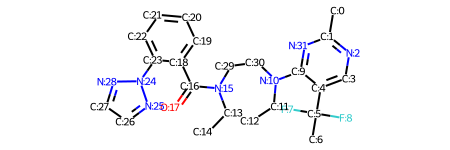

高活性分子： COc1ncc(C(F)(F)F)c(N2CCC(C)N(C(=O)c3ccccc3-n3nccn3)CC2)n1


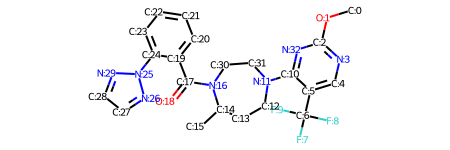

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.986, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.006, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.986, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.006, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom

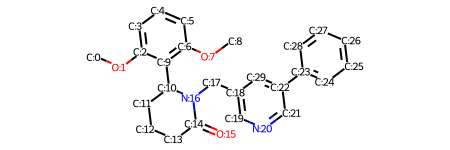

将第7个原子修改为S的分子： COc1cccc(SC)c1C1CCCC(=O)N1Cc1cncc(-c2ccccc2)c1


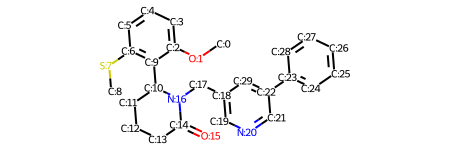

高活性分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1cccc(-c2ccccc2)c1


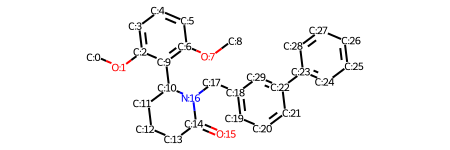

atom#0(f): {'B': 0.0, 'C': 0.986, 'N': 0.0, 'O': 0.0, 'F': 0.007, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 0.986, 'N': 0.0, 'O': 0.0, 'F': 0.007, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {

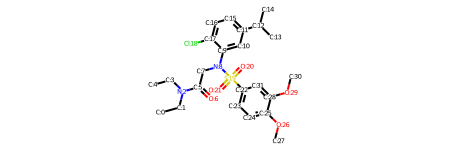

将第2个原子修改为C的分子： CCC(CC)C(=O)CN(c1cc(C(C)C)ccc1Cl)S(=O)(=O)c1ccc(OC)c(OC)c1


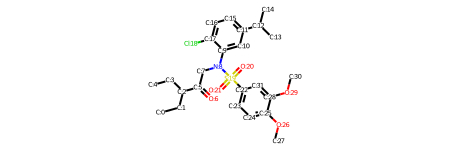

高活性分子： CCN(CC)C(=O)CN(c1cc(N(C)C)ccc1Cl)S(=O)(=O)c1ccc(OC)c(OC)c1


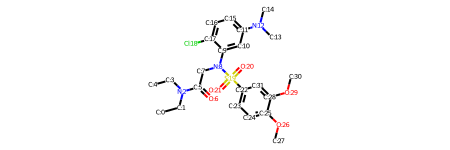

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#1

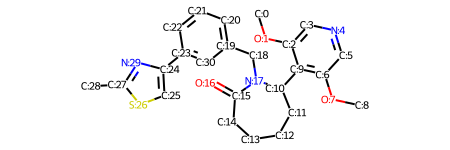

将第4个原子修改为C的分子： COc1cccc(OC)c1C1CCCCC(=O)N1Cc1cccc(-c2csc(C)n2)c1


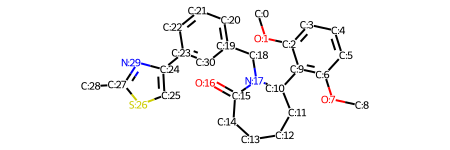

高活性分子： COc1cccc(OC)c1C1CCCCC(=O)N1Cc1cccc(-c2csc(C)n2)c1


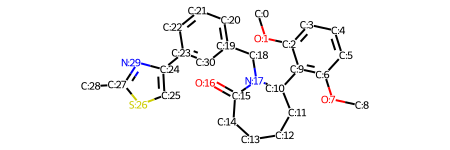

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.985, 'N': 0.0, 'O': 0.0, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.985, 'N': 0.0, 'O': 0.0, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#15(

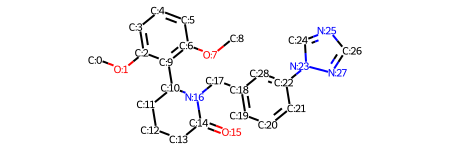

将第25个原子修改为C的分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1cccc(-n2cccn2)c1


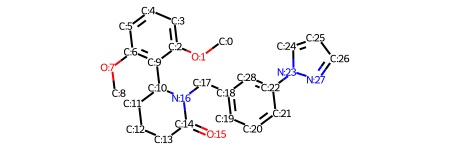

高活性分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1cccc(-n2cccn2)c1


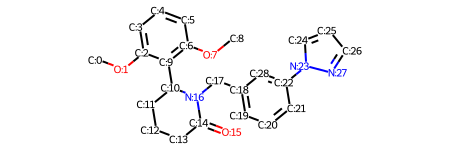

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#9(f): {'B': 0.0, 'C': 0.989, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#9(f+d): {'B': 0.0, 'C': 0.989, 'N': 0.0, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): 

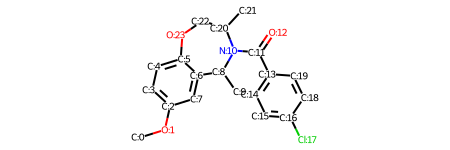

将第10个原子修改为C的分子： COc1ccc2c(c1)C(C)C(C(=O)N1CCC(Cl)CC1)C(C)CO2


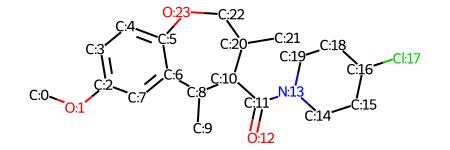

高活性分子： CSc1ccc2c(c1)C(C)N(C(=O)c1ccc(Cl)cc1)C(C)CO2


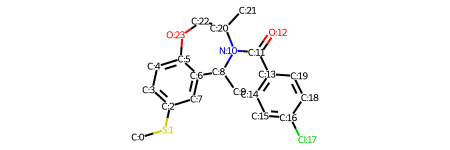

atom#0(f): {'B': 0.0, 'C': 0.988, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.992, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.976, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.004, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.008, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
---------------------------------------------------------------------------------------------------------

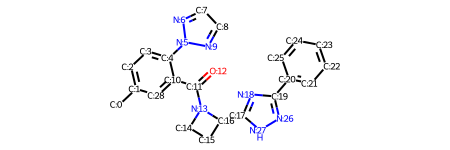

将第13个原子修改为C的分子： Cc1ccc(-n2nccn2)c(C(=O)C2CCC2c2nc(-c3ccccc3)n[nH]2)c1


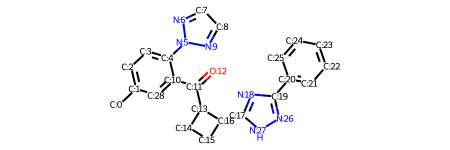

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCC2c2nc(-c3ccccc3C)no2)c1


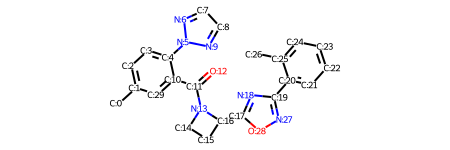

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.008, 'C': 0.506, 'N': 0.001, 'O': 0.012, 'F': 0.148, 'Si': 0.008, 'P': 0.008, 'S': 0.023, 'Cl': 0.009, 'As': 0.008, 'Se': 0.008, 'Br': 0.155, 'Te': 0.008, 'I': 0.008, 'At': 0.008, 'other': 0.08} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.0, 'C': 0.007, 'N': 0.0, 'O': 0.005, 'F': 0.969, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.005, 'As': 0.0, 'Se': 0.0, 'Br': 0.012, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.005, 'C': 0.005, 'N': 0.008, 'O': 0.091, 'F': 0.165, 'Si': 0.005, 'P': 0.005, 'S': 0.002, 'Cl': 0.448, 'As': 0.005, 'Se': 0.005, 'Br': 0.207, 'Te': 0.005, 'I': 0.005, 'At': 0.005, 'other': 0.032} 
---------------------------------------------------------------------

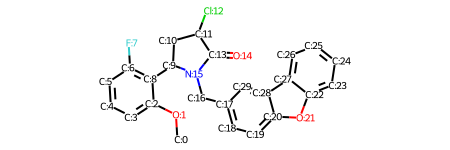

将第7个原子修改为Cl的分子： COc1cccc(Cl)c1C1CC(Cl)C(=O)N1Cc1ccc2oc3ccccc3c2c1


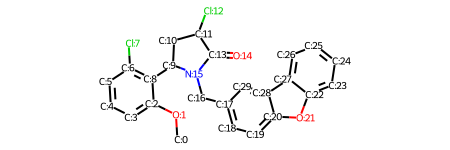

高活性分子： COc1cccc(F)c1C1CC(F)C(=O)N1Cc1ccc2oc3ccccc3c2c1


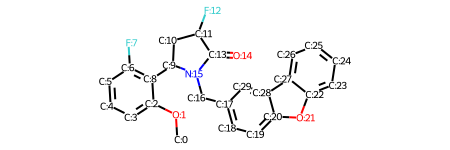

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#15(f): {'

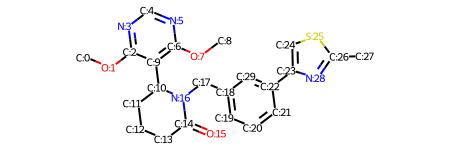

将第3个原子修改为C的分子： COc1ccnc(OC)c1C1CCCC(=O)N1Cc1cccc(-c2csc(C)n2)c1


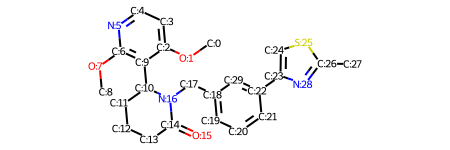

高活性分子： COc1ccnc(OC)c1C1CCCC(=O)N1Cc1cccc(-c2csc(C)n2)c1


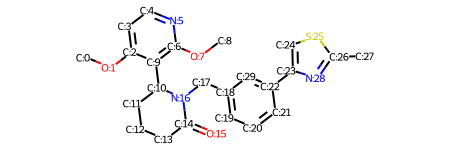

congratulations: [8] [70]
atom#0(f): {'B': 0.0, 'C': 0.982, 'N': 0.0, 'O': 0.0, 'F': 0.009, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.986, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.005, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#19(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#19(f+d): {'B': 0.002, 'C': 0.003, 'N': 0.006, 'O': 0.885, 'F': 0.01, 'Si': 0.002, 'P': 0.002, 'S': 0.047, 'Cl': 0.002, 'As': 0.002, 'Se': 0.002, 'Br': 0.029, 'Te': 0.002, 'I': 0.002, 'At': 0.002, 'other': 0.005} 
--------------------------------------------------------------

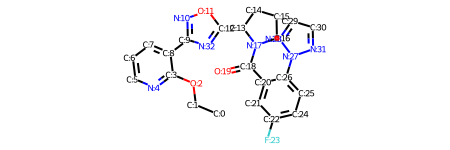

将第23个原子修改为C的分子： CCOc1ncccc1-c1noc(C2CCCN2C(=O)c2cc(C)ccc2-n2nccn2)n1


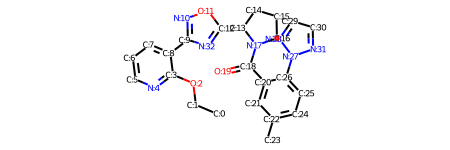

高活性分子： CCOc1ncccc1-c1noc(C2CCCN2C(=O)c2cc(C)ccc2-n2nccn2)n1


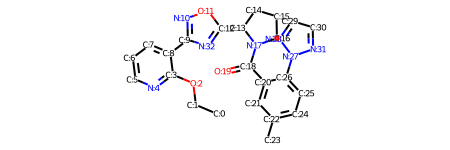

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.979, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.009, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#16(f): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.986, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#16(f+d): {'B': 0.003, 'C': 0.008, 'N': 0.012, 'O': 0.76, 'F': 0.006, 'Si': 0.003, 'P': 0.003, 'S': 0.148, 'Cl': 0.001, 'As': 0.003, 'Se': 0.003, 'Br': 0.037, 'Te': 0.003, 'I': 0.003, 'At': 0.003, 'other': 0.006} 
-------------------------------------------------------------------------------------

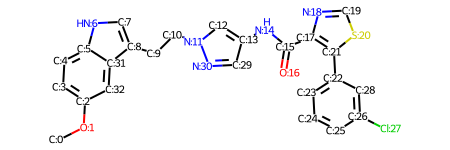

将第6个原子修改为C的分子： COC1CCC2CCC(CCn3cc(NC(=O)c4ncsc4-c4cccc(Cl)c4)cn3)C2C1


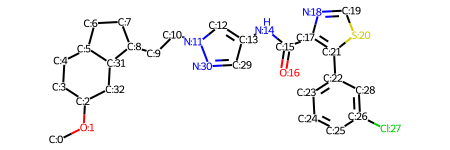

高活性分子： COc1ccc2[nH]cc(CCn3cc(NC(=O)c4ncoc4-c4cccc(Cl)c4)cn3)c2c1


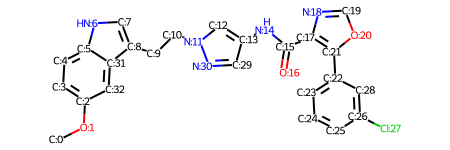

atom#0(f): {'B': 0.0, 'C': 0.977, 'N': 0.0, 'O': 0.0, 'F': 0.014, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.001, 'C': 0.108, 'N': 0.0, 'O': 0.009, 'F': 0.774, 'Si': 0.001, 'P': 0.001, 'S': 0.001, 'Cl': 0.011, 'As': 0.001, 'Se': 0.001, 'Br': 0.08, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.005} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.0, 'C': 0.007, 'N': 0.0, 'O': 0.005, 'F': 0.97, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.005, 'As': 0.0, 'Se': 0.0, 'Br': 0.011, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.002, 'C': 0.005, 'N': 0.002, 'O': 0.055, 'F': 0.488, 'Si': 0.002, 'P': 0.002, 'S': 0.001, 'Cl': 0.302, 'As': 0.002, 'Se': 0.002, 'Br': 0.123, 'Te': 0.002, 'I': 0.002, 'At': 0.002, 'other': 0.008} 
-------------------------------------------------------------------------

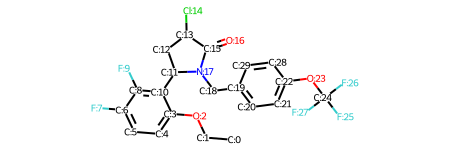

将第0个原子修改为F的分子： O=C1C(Cl)CC(c2c(OCF)ccc(F)c2F)N1Cc1ccc(OC(F)(F)F)cc1


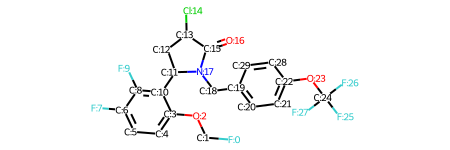

高活性分子： CCOc1ccc(F)c(F)c1C1CC(F)C(=O)N1Cc1ccc(OC(F)(F)F)cc1


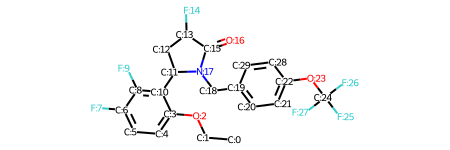

atom#0(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f):

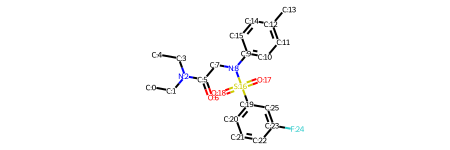

将第2个原子修改为C的分子： CCC(CC)C(=O)CN(c1ccc(C)cc1)S(=O)(=O)c1cccc(F)c1


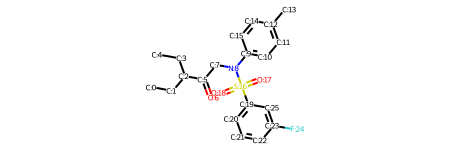

高活性分子： CCN(CC)C(=O)CN(c1ccc(C)cc1)S(=O)(=O)c1cccc(C)c1


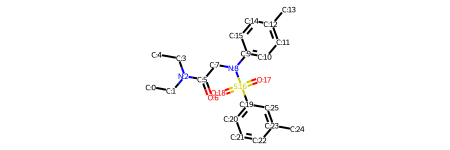

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#1

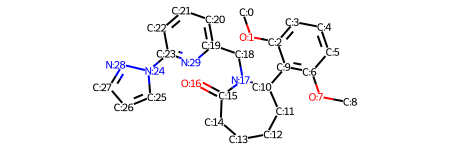

将第17个原子修改为C的分子： COc1cccc(OC)c1C1CCCCC(=O)C1Cc1cccc(-n2cccn2)n1


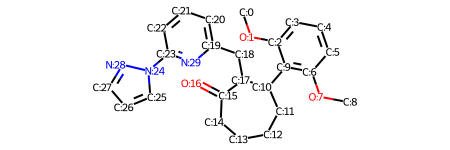

高活性分子： COc1cccc(OC)c1C1CCCCC(=O)N1Cc1cccc(-n2cccn2)c1


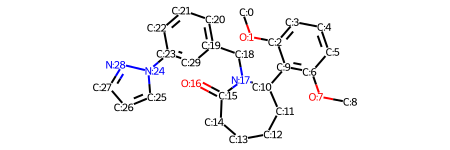

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.987, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.005, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#15(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#15(f+d): {'B': 0.001, 'C': 0.002, 'N': 0.004, 'O': 0.916, 'F': 0.007, 'Si': 0.001, 'P': 0.001, 'S': 0.033, 'Cl': 0.001, 'As': 0.001, 'Se': 0.001, 'Br': 0.022, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.003} 
--------------------------------------------------------------------------------------

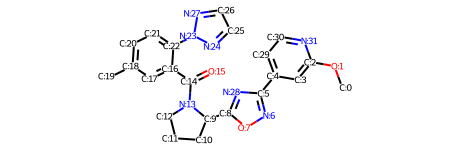

将第23个原子修改为C的分子： COc1cc(-c2noc(C3CCCN3C(=O)c3cc(C)ccc3C3NCCN3)n2)ccn1


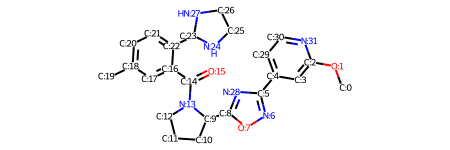

高活性分子： COc1cccc(-c2noc(C3CCCN3C(=O)c3cc(C)ccc3-n3nccn3)n2)c1


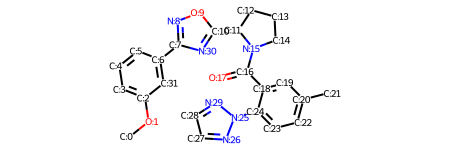

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.978, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.007, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.978, 'F': 0.006, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.007, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.974, 'F': 0.013, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#3(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.974, 'F': 0.013, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.006, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
-----------------------------------------------------------------------------------------------

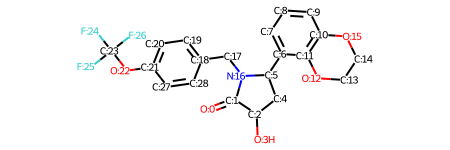

将第16个原子修改为C的分子： O=C1C(O)CC(c2cccc3c2OCCO3)C1Cc1ccc(OC(F)(F)F)cc1


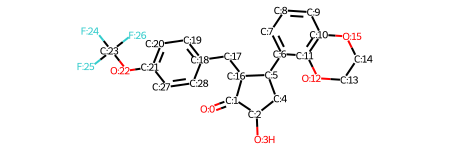

高活性分子： O=C1C(Cl)CC(c2cccc3c2OCCO3)N1Cc1ccc(OC(F)(F)F)cc1


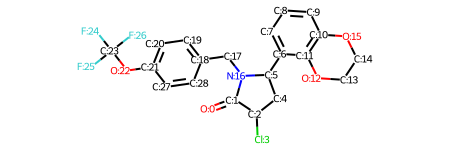

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.001, 'C': 0.956, 'N': 0.0, 'O': 0.0, 'F': 0.021, 'Si': 0.001, 'P': 0.001, 'S': 0.004, 'Cl': 0.0, 'As': 0.001, 'Se': 0.001, 'Br': 0.012, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.003} 
------------------------------------------------------------------------------------------------------------
atom#16(f): {'B': 0.0, 'C': 0.0, 'N': 0.002, 'O': 0.986, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#16(f+d): {'B': 0.001, 'C': 0.0, 'N': 0.009, 'O': 0.955, 'F': 0.004, 'Si': 0.001, 'P': 0.001, 'S': 0.002, 'Cl': 0.011, 'As': 0.001, 'Se': 0.001, 'Br': 0.012, 'Te': 0.001, 'I': 0.001, 'At': 0.001, 'other': 0.002} 
----------------------------------------------------------------------

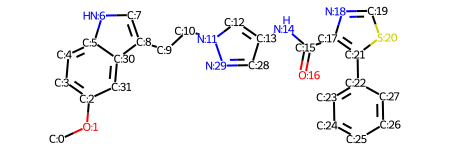

将第9个原子修改为other的分子： COc1ccc2[nH]cc(*Cn3cc(NC(=O)c4ncsc4-c4ccccc4)cn3)c2c1


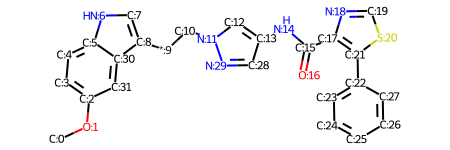

高活性分子： COc1ccc2[nH]cc(CCn3cc(NC(=O)c4ncoc4-c4ccccc4)cn3)c2c1


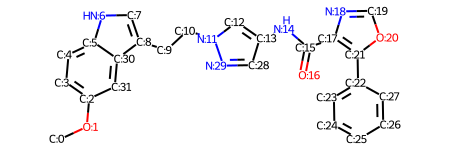

atom#0(f): {'B': 0.0, 'C': 0.992, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.966, 'N': 0.0, 'O': 0.0, 'F': 0.006, 'Si': 0.0, 'P': 0.001, 'S': 0.013, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.009, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.001, 'O': 0.981, 'F': 0.005, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.005, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#12(f+d): {'B': 0.009, 'C': 0.084, 'N': 0.011, 'O': 0.307, 'F': 0.021, 'Si': 0.009, 'P': 0.009, 'S': 0.384, 'Cl': 0.002, 'As': 0.009, 'Se': 0.009, 'Br': 0.095, 'Te': 0.009, 'I': 0.009, 'At': 0.009, 'other': 0.025} 
-----------------------------------------------------------------------------------

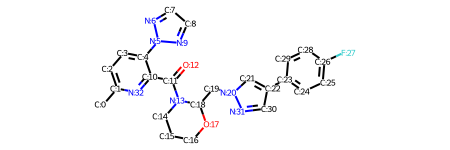

将第32个原子修改为C的分子： CC1CCC(n2nccn2)C(C(=O)N2CCCOC2Cn2cc(-c3ccc(F)cc3)cn2)C1


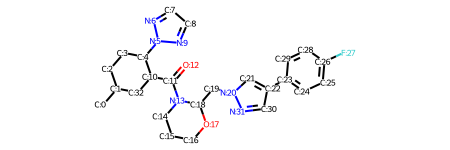

高活性分子： Cc1ccc(-n2nccn2)c(C(=O)N2CCCOC2Cn2cc(-c3ccc(F)cc3)cn2)c1


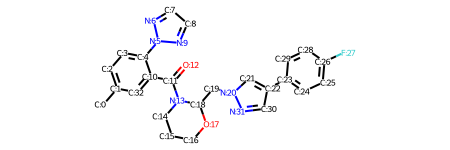

atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#0(f+d): {'B': 0.0, 'C': 0.956, 'N': 0.0, 'O': 0.0, 'F': 0.023, 'Si': 0.0, 'P': 0.001, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.011, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.002} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.003, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.001} 
atom#8(f+d): {'B': 0.0, 'C': 0.956, 'N': 0.0, 'O': 0.0, 'F': 0.023, 'Si': 0.0, 'P': 0.001, 'S': 0.003, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.011, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.002} 
------------------------------------------------------------------------------------------------------------


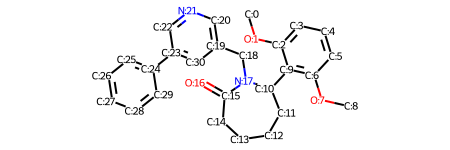

将第13个原子修改为other的分子： COc1cccc(OC)c1C1CC*CC(=O)N1Cc1cncc(-c2ccccc2)c1


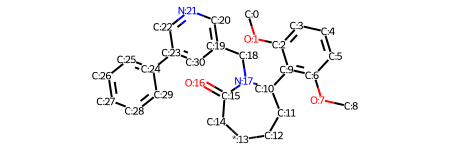

高活性分子： COc1cccc(OC)c1C1CCCCC(=O)N1Cc1cccc(-c2ccccc2)c1


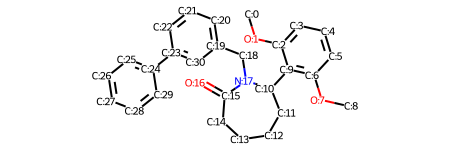

congratulations: [9] [80]
atom#0(f): {'B': 0.0, 'C': 0.99, 'N': 0.0, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.002, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.004, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.005, 'C': 0.188, 'N': 0.001, 'O': 0.018, 'F': 0.438, 'Si': 0.005, 'P': 0.005, 'S': 0.008, 'Cl': 0.04, 'As': 0.005, 'Se': 0.005, 'Br': 0.241, 'Te': 0.005, 'I': 0.005, 'At': 0.005, 'other': 0.026} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.01, 'N': 0.0, 'O': 0.006, 'F': 0.968, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.003, 'As': 0.0, 'Se': 0.0, 'Br': 0.011, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.004, 'C': 0.007, 'N': 0.003, 'O': 0.104, 'F': 0.406, 'Si': 0.004, 'P': 0.004, 'S': 0.001, 'Cl': 0.271, 'As': 0.004, 'Se': 0.004, 'Br': 0.162, 'Te': 0.004, 'I': 0.004, 'At': 0.004, 'other': 0.016} 
----------------------------------------------

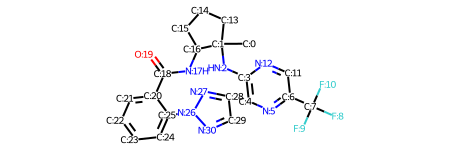

将第0个原子修改为F的分子： O=C(NC1CCCC1(F)Nc1cnc(C(F)(F)F)cn1)c1ccccc1-n1nccn1


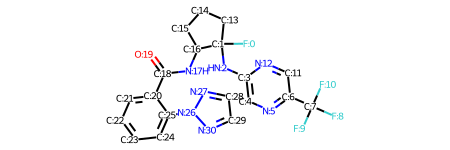

高活性分子： CC1(Nc2ccc(C(F)(F)F)cn2)CCCC1NC(=O)c1ccccc1-n1nccn1


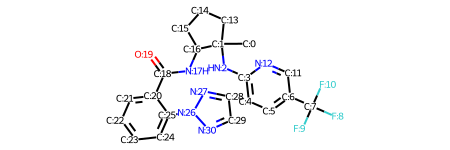

congratulations: [9] [81]
successfully/total generated molecules = {'Top-1': '9/81'}
----------
Reconstruction: 1.0000 
Validity: 0.2840
Unique: 0.9630 
Novelty: 1.0000 
Average: 0.8117


In [16]:
stopper.load_checkpoint(model)
stopper_afse.load_checkpoint(amodel)
stopper_generate.load_checkpoint(gmodel)
    
reconstruction_rate, success_validity, unique_rate, novelty_rate, success_smiles, init_smiles, generated_smiles, test_r2, test_MSE, test_predict = eval(model, amodel, gmodel, test_df, topn=1, generate=True, validate=True, print_flag=True)

test_predict = np.array(test_predict)

print("----------")
print('Reconstruction: %.4f'%reconstruction_rate,'\nValidity: %.4f'%success_validity)
print('Unique: %.4f'%unique_rate,'\nNovelty: %.4f'%novelty_rate, 
      '\nAverage: %.4f'%((reconstruction_rate+success_validity+unique_rate+novelty_rate)/4))

In [ ]:
generated_df = pd.DataFrame([])
generated_df['smiles'] = generated_smiles
generated_df['value'] = 0
generated_df = add_canonical_smiles(generated_df)
feature_dicts = save_smiles_dicts(generated_df['cano_smiles'],filename)
generated_df = generated_df[generated_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
generated_df = generated_df.reset_index(drop=True)
generated_smiles_valid = generated_df.cano_smiles.values
_, _, _, _, _, _, _,_, generated_smiles_2nd , _, _, generated_predict = eval(model, amodel, gmodel, generated_df, topn=1, generate=True, print_flag=True)
generated_predict = np.array(generated_predict)
generated_df['pred_value'] = generated_predict

In [ ]:
print('target_file:',train_filename)
print('inactive_file:',test_filename)
np.savez('./result/G_AFSE_'+file1, feature_list, d_list, init_smiles, generated_smiles, generated_smiles_valid, success_smiles, test_predict, generated_predict)
Generate_Data = np.load('./result/G_AFSE_'+file1+".npz", allow_pickle=True)
print(Generate_Data['arr_0'].shape, Generate_Data['arr_1'].shape, Generate_Data['arr_2'].shape, Generate_Data['arr_3'].shape, Generate_Data['arr_4'].shape, Generate_Data['arr_5'].shape, Generate_Data['arr_6'].shape, Generate_Data['arr_7'].shape)

In [17]:
import math
import pickle
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import os
import os.path as op
 
#get_sa_score start
_fscores = None
 
def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:
    if name == "fpscores":
        name = op.join(os.getcwd(), name)
        # name = op.join(op.dirname(__file__), name)
    data = pickle.load(gzip.open('%s.pkl.gz' % name))
    outDict = {}
    for i in data:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict
 
 
def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro
 
def calculateScore(m):
    if _fscores is None:
        readFragmentScores()
 
    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m,
                                            2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf
 
    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1
 
    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    # macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)
 
    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty
 
    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5
 
    sascore = score1 + score2 + score3
 
    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0
 
    return sascore

def SA_score(mols:list):
    ss = []
    readFragmentScores("fpscores")
#     print('smiles\tsa_score')
    for m in mols:
        s = calculateScore(m)
        smiles = Chem.MolToSmiles(m)
        ss.append(s)
#         print(smiles + "\t" + "\t%3f" % s)
    return ss

In [18]:
QED_scores_init = []
logP_scores_init = []
init_mols = []
init_valid_smiles = []
smiles_num = len(init_smiles)
for i in range(smiles_num):
    mol = Chem.MolFromSmiles(init_smiles[i])
    if mol is not None:
        init_mols.append(mol)
        init_valid_smiles.append(Chem.MolToSmiles(mol))
        QED = Chem.QED.default(mol)
        QED_scores_init.append(QED)
        logP = Chem.Crippen.MolLogP(mol)
        logP_scores_init.append(logP)
SA_scores_init = np.array(SA_score(init_mols))
QED_scores_init = np.array(QED_scores_init)
QED_scores_init_ranked = np.sort(QED_scores_init)
logP_scores_init = np.array(logP_scores_init)

QED_scores = []
logP_scores = []
generated_mols = []
generated_valid_smiles = []
smiles_num = len(generated_smiles)
for i in range(smiles_num):
    mol = Chem.MolFromSmiles(generated_smiles[i])
    if mol is not None:
        generated_mols.append(mol)
        generated_valid_smiles.append(Chem.MolToSmiles(mol))
        QED = Chem.QED.default(mol)
        QED_scores.append(QED)
        logP = Chem.Crippen.MolLogP(mol)
        logP_scores.append(logP)
SA_scores = np.array(SA_score(generated_mols))
QED_scores = np.array(QED_scores)
QED_scores_ranked = np.sort(QED_scores)
logP_scores = np.array(logP_scores)
print('QED Rank:', QED_scores_ranked[-5:],
      '\nQED（越大类药性越高）: %.4f'%max(QED_scores), '%.4f'%(sum(QED_scores)/smiles_num),'%.4f'%min(QED_scores),
      '\nSA（越小可合成性越高）: %.4f'%max(SA_scores), '%.4f'%(sum(SA_scores)/smiles_num),'%.4f'%min(SA_scores),
      '\nlogP（越大疏水性越好）: %.4f'%max(logP_scores), '%.4f'%(sum(logP_scores)/smiles_num),'%.4f'%min(logP_scores),
      )

QED Rank: [0.77372762 0.78028927 0.7849973  0.7849973  0.83714806] 
QED（越大类药性越高）: 0.8371 0.5471 0.3076 
SA（越小可合成性越高）: 4.2806 3.3844 2.3306 
logP（越大疏水性越好）: 6.8276 4.3661 2.6173


In [19]:
I_SMILES_Dict = {init_valid_smiles[i]: [QED_scores_init[i], SA_scores_init[i], logP_scores_init[i]] for i in range(len(init_valid_smiles))}
G_SMILES_Dict = {generated_valid_smiles[i]: [QED_scores[i], SA_scores[i], logP_scores[i]] for i in range(len(generated_valid_smiles))}
print(len(init_valid_smiles),len(generated_valid_smiles))
for i, smiles in enumerate(success_smiles):
    index = generated_valid_smiles.index(smiles)
    try:
        print('原始测试集分子：',init_valid_smiles[index],
              '\n原始测试集分子活性值：%.4f'%(train_df['value'].values[train_df.cano_smiles.values==init_valid_smiles[index]][0].astype(float)+9),
             '\nQED（越大类药性越高）: %.4f'%I_SMILES_Dict[init_valid_smiles[index]][0],
              '\nSA（越小可合成性越高）: %.4f'%I_SMILES_Dict[init_valid_smiles[index]][1],
              '\nlogP（越大疏水性越好）: %.4f'%I_SMILES_Dict[init_valid_smiles[index]][2],
             '\n\n成功生成的高活性分子：',smiles,
              '\nActivity（越大药效越好）: %.4f'%(test_df['value'].values[test_df.cano_smiles.values==smiles][0].astype(float)+9),
             '\nQED（越大类药性越高）: %.4f'%G_SMILES_Dict[smiles][0],
              '\nSA（越小可合成性越高）: %.4f'%G_SMILES_Dict[smiles][1],
              '\nlogP（越大疏水性越好）: %.4f'%G_SMILES_Dict[smiles][2],
             '\n------------------------------------------------------------------------------------------------------------')
    except Exception as e:
        print('错误明细是:',e.__class__.__name__,e)
        continue

81 81
原始测试集分子： CCOc1ccccc1-c1noc(C2CCCN2C(=O)c2cc(F)ccc2-n2nccn2)n1 
原始测试集分子活性值：6.9788 
QED（越大类药性越高）: 0.4419 
SA（越小可合成性越高）: 3.0856 
logP（越大疏水性越好）: 3.8324 

成功生成的高活性分子： CCOc1ccccc1-c1noc(C2CCCN2C(=O)c2cc(C)ccc2-n2nccn2)n1 
Activity（越大药效越好）: 8.3979 
QED（越大类药性越高）: 0.4431 
SA（越小可合成性越高）: 3.0689 
logP（越大疏水性越好）: 4.0017 
------------------------------------------------------------------------------------------------------------
原始测试集分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1ccnc(N2CCCC2)c1 
原始测试集分子活性值：5.6861 
QED（越大类药性越高）: 0.7412 
SA（越小可合成性越高）: 2.8200 
logP（越大疏水性越好）: 3.9528 

成功生成的高活性分子： COc1cccc(OC)c1C1CCCC(=O)N1Cc1cccc(N2CCCC2)c1 
Activity（越大药效越好）: 7.5086 
QED（越大类药性越高）: 0.7204 
SA（越小可合成性越高）: 2.6935 
logP（越大疏水性越好）: 4.5578 
------------------------------------------------------------------------------------------------------------
原始测试集分子： CC1COc2ccc(F)cc2C(C)N1C(=O)c1ccc(Cl)cc1 
原始测试集分子活性值：5.5229 
QED（越大类药性越高）: 0.7706 
SA（越小可合成性越高）: 3.0386 
logP（越大疏水性越好）: 4.4634 

成功生成的高活性分子： Cc1ccc2c(c1)C(C)N(C(=O)c1

In [ ]:
# print('target_file:',train_filename)
# print('inactive_file:',test_filename)
# np.savez('./result/G_AFSE_'+file1, epoch_list, train_f_list, train_d_list, 
#          train_predict_list, train_y_list, val_f_list, val_d_list, val_predict_list, val_y_list, test_f_list, 
#          test_d_list, test_predict_list, test_y_list)
# sim_space = np.load('./result/G_AFSE_'+file1+".npz")
# print(sim_space['arr_10'].shape)

In [ ]:
# one_hot_loss += py_sigmoid_focal_loss(refer_atom_list[i,:l,:16], x_atom[i,:l,:16], alpha=atom_weights)- \
#                           ((validity_mask[i,:l]*torch.log(1-atom_list[i,:l,:16]+1e-9)).sum(-1).sum(-1)/(validity_mask[i,:l].sum(-1).sum(-1)+1e-9))
        